This project is an assignment from EE4211 DATA SCIENCE FOR THE INTERNET OF THINGS. This is an open-ended project in which the students are given a set of gas consumption data and are required to analyse the data and provide insights on the data.

In [2]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns

import datetime

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.cluster import KMeans

In [3]:
#hide all warnings
import warnings
warnings.filterwarnings('ignore')

## 1. Interim (10 pts)

**1.1 How many houses are included in the measurement study? Are there any malfunctioning meters? If so, identify them and the time periods where they were malfunctioning.**

In [4]:
df = pd.read_csv("dataport-export_gas_oct2015-mar2016.csv")
df.sample(5)

,localminute,dataid,meter_value
1274798,2016-02-20 02:10:17.400167-06,5814,814144
1028097,2016-01-24 00:51:52.706821-06,9295,175440
1408615,2016-03-07 01:57:37.151855-06,5785,186862
165018,2015-10-19 18:57:05-05,9295,158678
642256,2015-12-11 09:29:21-06,5814,806274


In [5]:
# Find the size of the data

print("The number of row enteries in the data is {:,}".format(df.shape[0]))
print("The number of columns in the data is {}".format(df.shape[1]))

The number of row enteries in the data is 1,584,823
The number of columns in the data is 3


In [6]:
# Find the number of unique element in the 'dataid' column

num_houses = df['dataid'].nunique()
print("The number of houses that are included in the study is {}".format(num_houses))

The number of houses that are included in the study is 157


In [7]:
# This code should list out all the unique value in 'dataid' i.e show all the ID of the households

list_houses = df['dataid'].unique() # return type: class 'numpy.ndarray'
print("The dataID of all the houses are:")
print()

print(sorted(list_houses))

The dataID of all the houses are:

[35, 44, 77, 94, 114, 187, 222, 252, 370, 483, 484, 661, 739, 744, 871, 1042, 1086, 1103, 1185, 1283, 1403, 1415, 1507, 1556, 1589, 1619, 1697, 1714, 1718, 1790, 1791, 1792, 1800, 1801, 2018, 2034, 2072, 2094, 2129, 2233, 2335, 2378, 2449, 2461, 2470, 2575, 2638, 2645, 2755, 2814, 2818, 2945, 2946, 2965, 2980, 3036, 3039, 3134, 3310, 3367, 3527, 3544, 3577, 3635, 3723, 3778, 3849, 3893, 3918, 4029, 4031, 4193, 4228, 4296, 4352, 4356, 4373, 4421, 4447, 4514, 4671, 4732, 4767, 4874, 4998, 5129, 5131, 5193, 5275, 5317, 5395, 5403, 5439, 5484, 5545, 5636, 5658, 5785, 5810, 5814, 5892, 5972, 6101, 6412, 6505, 6578, 6673, 6685, 6830, 6836, 6863, 6910, 7016, 7017, 7030, 7117, 7287, 7429, 7460, 7566, 7674, 7682, 7739, 7741, 7794, 7900, 7919, 7965, 7989, 8059, 8084, 8086, 8155, 8156, 8244, 8386, 8467, 8703, 8829, 8890, 8967, 9052, 9121, 9134, 9160, 9278, 9295, 9474, 9600, 9620, 9631, 9639, 9729, 9766, 9849, 9956, 9982]


The raw data presents the time as in a 'localtime' format,in which the date,hours,minutes and seconds are concatinated together. In order to extract each data individually, we will do some modifications to the pandas dataframe to get those value. The code to achieve this objective is shown below.

In [8]:
df_modify = df.copy()

# We would like to split the 'localtime' data into Date, Hours, Minutes and Seconds
# The data split will be as such:
# 2015-10-01 00:00:10-05 ---- Example
# <--Date--> <H>:<M>:<S>


df_modify['Year'] = df_modify['localminute'].apply(lambda x: int(x.split(" ")[0].split("-")[0]))
df_modify['Month'] = df_modify['localminute'].apply(lambda x: int(x.split(" ")[0].split("-")[1]))
df_modify['Day'] = df_modify['localminute'].apply(lambda x: int(x.split(" ")[0].split("-")[2]))
df_modify['Hour'] = df_modify['localminute'].apply(lambda x: int(x.split(" ")[1].split(":")[0]))
df_modify['Minute'] = df_modify['localminute'].apply(lambda x: int(x.split(" ")[1].split(":")[1]))
df_modify['Seconds'] = df_modify['localminute'].apply(lambda x: int(float(x.split(" ")[1].split(":")[2].split("-")[0])))

df_modify = df_modify.drop(columns=['localminute'])
df_modify = df_modify.sort_values(by=['dataid','Year','Month','Day','Hour','Minute','Seconds'])
df_modify.head()

,dataid,meter_value,Year,Month,Day,Hour,Minute,Seconds
83,35,93470,2015,10,1,0,14,44
244,35,93470,2015,10,1,0,42,34
723,35,93470,2015,10,1,2,2,37
790,35,93470,2015,10,1,2,12,38
829,35,93470,2015,10,1,2,20,36


In [9]:
# These codes shows the different unique values for each individual columns.
# This would help us understand the different start and end dates for the data entries

print(df_modify['Year'].unique())
print(df_modify['Month'].unique())
print(df_modify['Day'].unique())
print(df_modify['Hour'].unique())

[2015 2016]
[10 11 12  1  2  3]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 27 28 29 30 31 26]
[ 0  2  3  4  5  6  7  8  9 11 12 15 16 17 18 19 21 22 23  1 10 13 14 20]


**Highlighting malfunctioning meters from the raw data**

First, we will filter all malfunction readings from the raw data.  
Our criteria for detecting potential malfunction record is: **previous reading > current reading**

In [10]:
df_malfunction = pd.DataFrame(np.zeros((5,12)),columns=['dataid', 'Previous meter', 'Current meter','Difference','Previous Date', 'Previous Hour','Previous Minute','Previous Second','Current Date', 'Current Hour','Current Minute','Current Second'])
df_malfunction

,dataid,Previous meter,Current meter,Difference,Previous Date,Previous Hour,Previous Minute,Previous Second,Current Date,Current Hour,Current Minute,Current Second
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
## Brute force approach to detecting the malfunction meter

def find_malfunction(df,df_malfunction):
    temp_list = []
    list_1 = df['dataid'].unique()
    previous_meter = 0
    previous_date = 0
    previous_hour = 0
    previous_minute = 0
    previous_second = 0

    current_meter = 0
    current_meter = 0
    current_date = 0
    current_hour = 0
    current_minute = 0
    current_second = 0
    difference = 0

    n = 0
    progress = 1

    for i in list_1:
        print("Currently processing dataid: {}".format(i))
        print("Process level : {}/{}".format(progress,len(list_1)))
        progress = progress + 1
        df_temp = df[df['dataid'] == i].reset_index()
        for index, row in df_temp.iterrows():
            if index == 0:
                previous_meter = row['meter_value']
                previous_date = str(row['Year']) +'-'+ str(row['Month']) +'-'+ str(row['Day'])
                previous_hour = row['Hour']
                previous_minute = row['Minute']
                previous_second = row['Seconds']
            else:
                current_meter = row['meter_value']
                current_date = str(row['Year']) +'-'+ str(row['Month']) +'-'+ str(row['Day'])
                current_hour = row['Hour']
                current_minute = row['Minute']
                current_second = row['Seconds']
                if current_meter < previous_meter:
                    difference = previous_meter - current_meter
                    temp_list.append(i)
                    temp_list.append(previous_meter)
                    temp_list.append(current_meter)
                    temp_list.append(difference)
                    temp_list.append(previous_date)
                    temp_list.append(previous_hour)
                    temp_list.append(previous_minute)
                    temp_list.append(previous_second)
                    temp_list.append(current_date)
                    temp_list.append(current_hour)
                    temp_list.append(current_minute)
                    temp_list.append(current_second)

                    df_malfunction.loc[n] = temp_list
                    n=n+1
                    temp_list.clear()

                previous_meter = row['meter_value']
                previous_date = str(row['Year']) +'-'+ str(row['Month']) +'-'+ str(row['Day'])
                previous_hour = row['Hour']
                previous_minute = row['Minute']
                previous_second = row['Seconds']           

        previous_meter = 0
        previous_date = 0
        previous_hour = 0
        previous_minute = 0
        previous_second = 0

        current_meter = 0
        current_meter = 0
        current_date = 0
        current_hour = 0
        current_minute = 0
        current_second = 0

        difference = 0

# # Generating data for malfunction ##
# find_malfunction(df_modify,df_malfunction)
# df_malfunction.to_csv('malfunction.csv',index=False)
# df_malfunction.sample(5)

## Reading malfunction data from previosuly saved CSV (for faster execution time) ##
# **drop the first coloumn as it contains the index of the dataframe**
# df_malfunction = pd.read_csv('malfunction.csv',sep=",").drop(df_malfunction.columns[0], axis=1) 
df_malfunction = pd.read_csv('malfunction.csv',sep=",")
df_malfunction['dataid'] = df_malfunction['dataid'].astype('int64', copy=False)
df_malfunction.head()

,dataid,Previous meter,Current meter,Difference,Previous Date,Previous Hour,Previous Minute,Previous Second,Current Date,Current Hour,Current Minute,Current Second
0,35,94014.0,94012.0,2.0,2015-10-20,8.0,53.0,16.0,2015-10-20,9.0,0.0,12.0
1,77,59260.0,59258.0,2.0,2015-10-20,20.0,7.0,57.0,2015-10-20,20.0,20.0,55.0
2,94,117626.0,117614.0,12.0,2015-11-1,1.0,10.0,7.0,2015-11-1,1.0,11.0,10.0
3,94,117626.0,117614.0,12.0,2015-11-1,1.0,13.0,9.0,2015-11-1,1.0,17.0,53.0
4,94,117626.0,117616.0,10.0,2015-11-1,1.0,19.0,10.0,2015-11-1,1.0,23.0,12.0


Let us now examine the severity of the malfunction  

The code below shows the different level of differences between each malfunctioning record

In [12]:
malfunction_values = sorted(list(df_malfunction['Difference'].unique()))
print(malfunction_values)

[2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 50.0, 8454.0, 8456.0, 8462.0, 8478.0, 8480.0, 8484.0, 8508.0, 8510.0, 8512.0, 8536.0, 8550.0, 11532.0, 11534.0, 11538.0, 11546.0, 11548.0, 11550.0, 11556.0, 11558.0, 11566.0, 11572.0, 11574.0, 11580.0, 11582.0, 11600.0, 11602.0, 11604.0, 11608.0, 11610.0, 11620.0, 11622.0, 11630.0, 11632.0, 11640.0, 11666.0, 11684.0, 11700.0, 11712.0, 11714.0, 12468.0, 12470.0, 12478.0, 12480.0, 12488.0, 12490.0, 12498.0, 12500.0, 12502.0, 12504.0, 12514.0, 12518.0, 12532.0, 12534.0, 12536.0, 13580.0, 13586.0, 13592.0, 13594.0, 13602.0, 13604.0, 13628.0, 13754.0, 13776.0, 13808.0, 13982.0, 14090.0, 15732.0, 15738.0, 15740.0, 15744.0, 15746.0, 15750.0, 15752.0, 15754.0, 15756.0, 15762.0, 15766.0, 15772.0, 15774.0, 15776.0, 15778.0, 15780.0, 15784.0, 15798.0, 15800.0, 15832.0, 15834.0, 15838.0, 15840.0, 15846.0, 15848.0, 15850.0, 15858.0, 15860.0, 15862.0, 15874.0, 15876.0, 15878.0, 16236.0, 16238.0, 16240.0, 16252.0, 16258.0, 16296.0, 16358.0, 16374.0, 17438.0, 174

From the values printed above, we can observe the different level of differences that the malfunctioning records have. From this data, we can separate them into levels such as **mild,moderate,severe** in order to differientate the levels of severity so that the government and gas companies can adapt to the changes easily and quickly.  

This is important as every 1000 cubic foot equates to USD$$13.61 (according to 2017 pricing from U.S. Energy Information Administration); Whenever there is a malfunction, profit is lowered.  

**Definition**  
mild: 0 < difference < 100  
moderate: 100 <= difference < 1000  
severe: 1000 <= difference 

In [13]:
def determine_serverity(x):
    difference = int(x['Difference'])
#     print(difference)
    if (0 <= difference) & (difference < 100):
        return 'Mild'
    elif (100 <= difference) & (difference < 1000):
        return 'Moderate'
    else:
        return 'Severe'
    
df_malfunction['Serverity'] = df_malfunction.apply(determine_serverity,axis=1)

df_malfunction.head()

,dataid,Previous meter,Current meter,Difference,Previous Date,Previous Hour,Previous Minute,Previous Second,Current Date,Current Hour,Current Minute,Current Second,Serverity
0,35,94014.0,94012.0,2.0,2015-10-20,8.0,53.0,16.0,2015-10-20,9.0,0.0,12.0,Mild
1,77,59260.0,59258.0,2.0,2015-10-20,20.0,7.0,57.0,2015-10-20,20.0,20.0,55.0,Mild
2,94,117626.0,117614.0,12.0,2015-11-1,1.0,10.0,7.0,2015-11-1,1.0,11.0,10.0,Mild
3,94,117626.0,117614.0,12.0,2015-11-1,1.0,13.0,9.0,2015-11-1,1.0,17.0,53.0,Mild
4,94,117626.0,117616.0,10.0,2015-11-1,1.0,19.0,10.0,2015-11-1,1.0,23.0,12.0,Mild


Now, we would like to do visualisation to see the different level of severity for each function. This would help us to get a better understanding of the severity for each malfunctioning house meter.

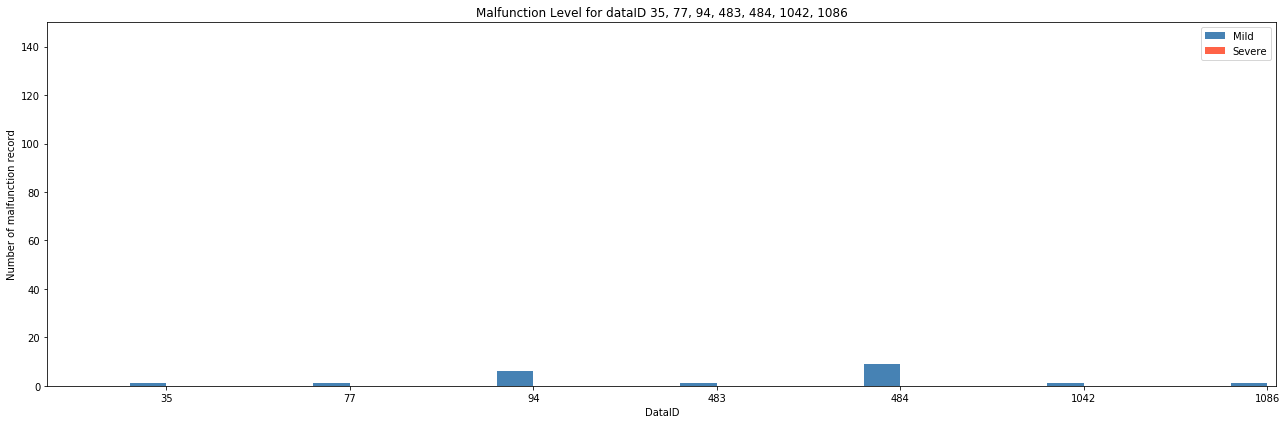

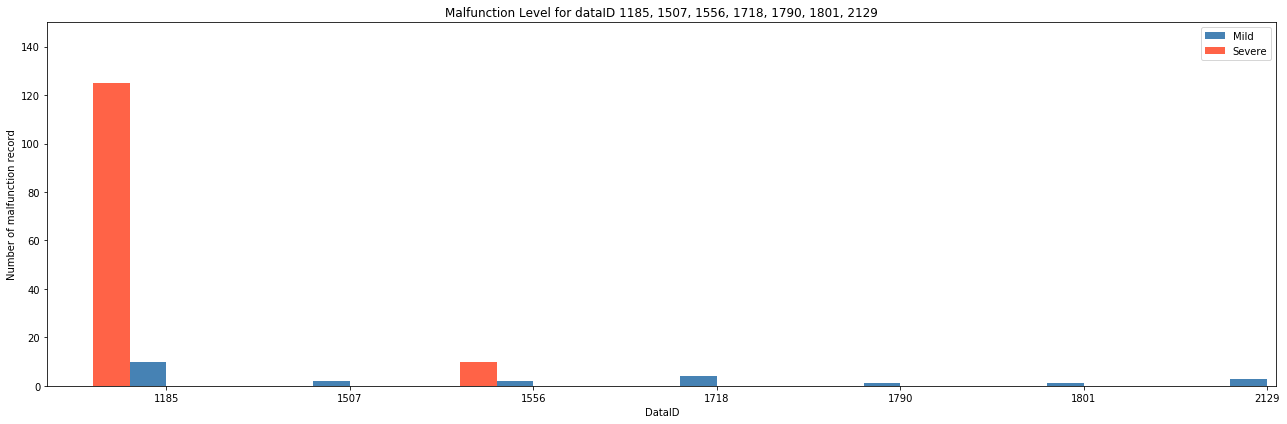

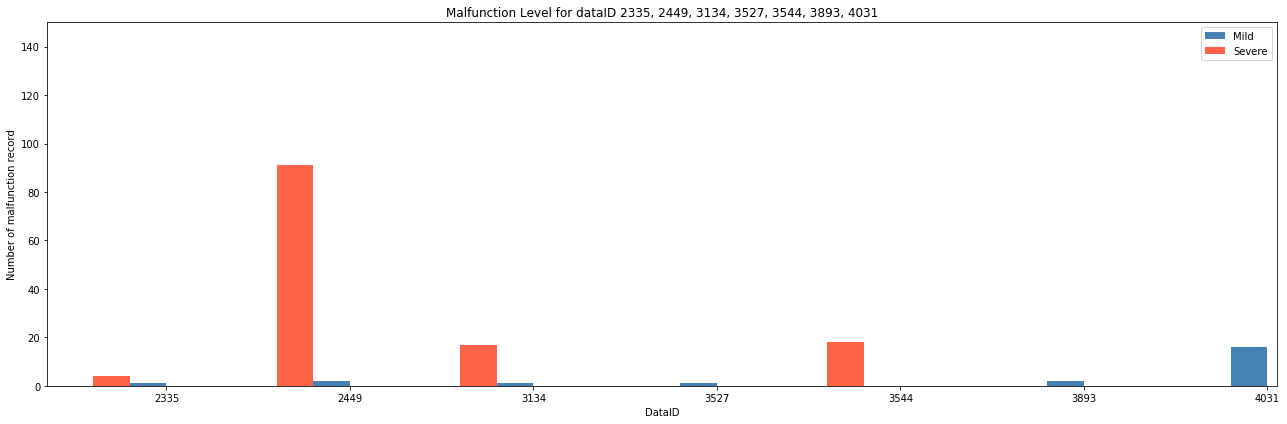

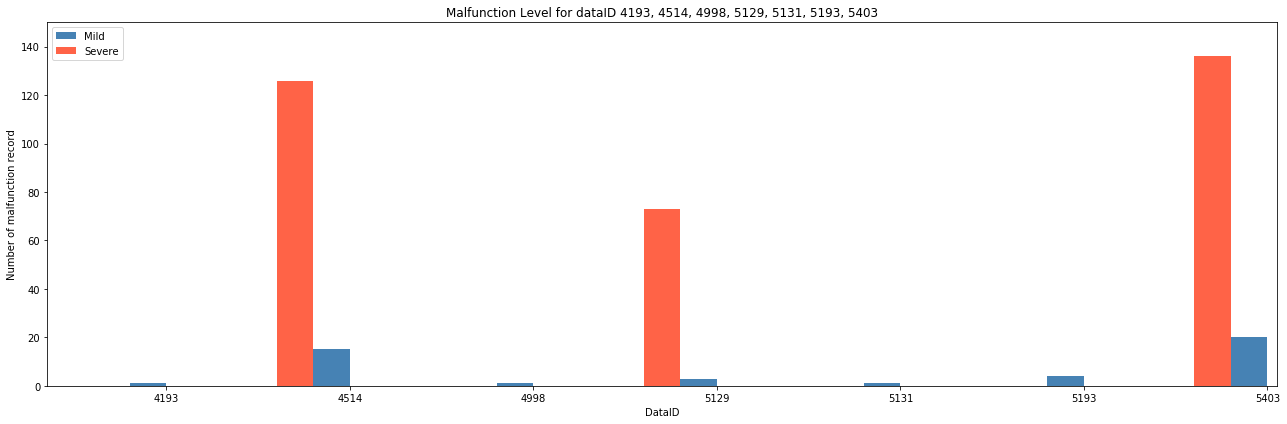

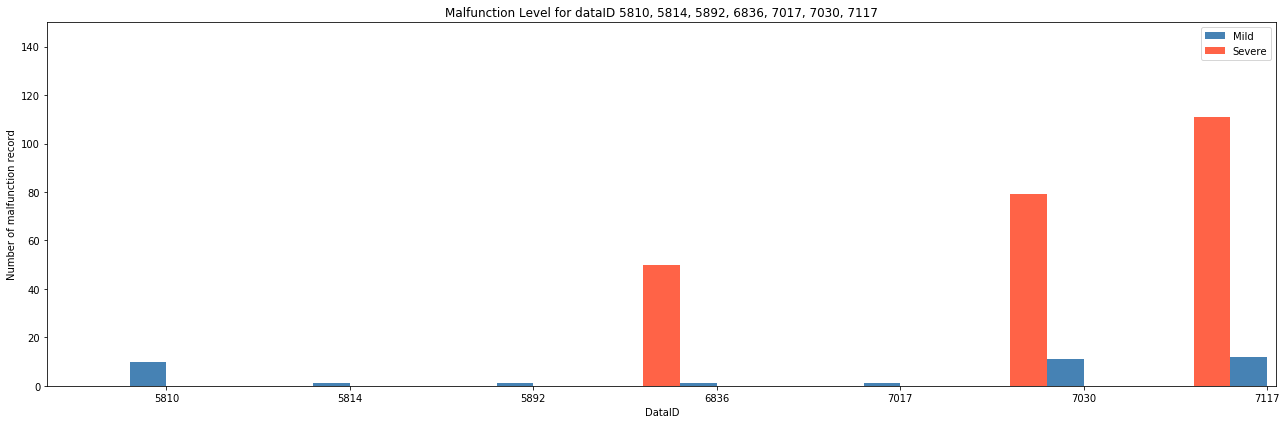

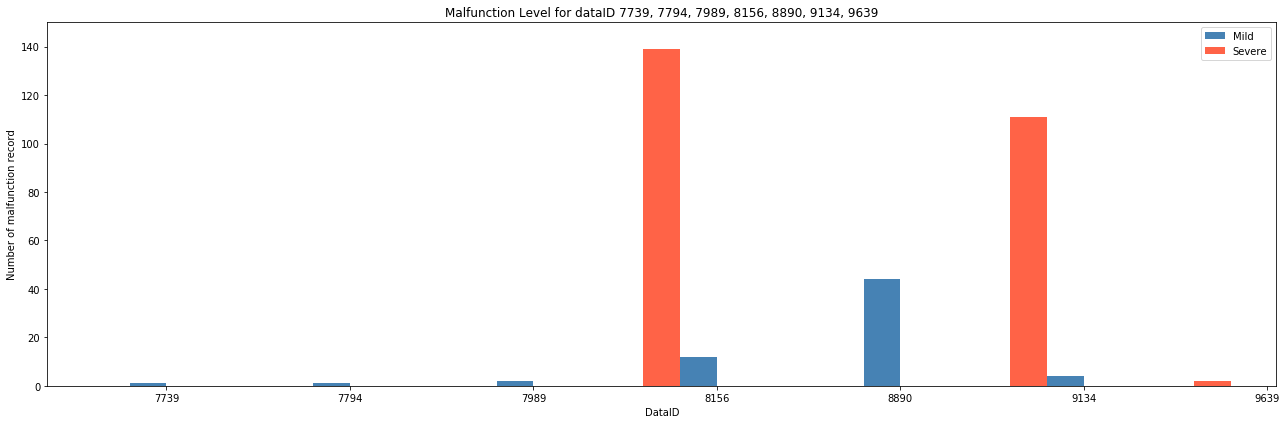

In [14]:
# Observe how many times the malfunction occured

df_malfunction_count = df_malfunction.groupby(['dataid','Serverity']).count().reset_index()
df_malfunction_count = df_malfunction_count[['dataid','Serverity','Previous meter']]
df_malfunction_count = df_malfunction_count.pivot(index='dataid', columns='Serverity', values='Previous meter').reset_index()
df_malfunction_count.columns = ['dataid','Mild','Severe'] 
df_malfunction_count = df_malfunction_count.fillna(0)

# Create a loop to plot certain amount of data at a time
num_malfunction = float(df_malfunction_count.shape[0])
interval = 7
num_plot = math.ceil(num_malfunction/interval)
start = 0
for i in range(1,num_plot):
    end = start + interval
    if end >= num_malfunction:
        end = int(num_malfunction) - 1
        
#     print((start,end))
    df_temp = df_malfunction_count.iloc[start:end]
    temp_list = df_temp['dataid'].unique().astype(str) 

    ## Plot the malfunction data
    # Create the figure
    fig = plt.figure(figsize=(18,6))

    # Add the subplot
    ax = fig.add_subplot(111)

    # Plot the values
    df_temp.plot(kind='bar', x='dataid', y='Mild', ax=ax, position=1, width=0.2, color='steelblue')
    df_temp.plot(kind='bar', x='dataid', y='Severe', ax=ax, position=2, width=0.2, color='tomato')

    # Configure the plot
    ax.set_title("Malfunction Level for dataID " + ', '.join(temp_list))
    ax.set_ylabel("Number of malfunction record")
    ax.set_xlabel("DataID")
    ax.set_ylim(ymin=0, ymax=150)
    plt.xticks(rotation='horizontal')
    plt.tight_layout()

    # show the plot
    plt.show()
    
    start = end



Now, we can create a list of dataid that has malfunctioning records and another list of dataid that does not have any malfunctioning records. From this point onwards, the plots shown in (1.2) and the correlation value in (1.3) are done on the batch of dataid that **do not have** any malfunctioning records.

In [15]:
num_malfunction = df_malfunction['dataid'].nunique()
print("The amount of malfunction meters are {}".format(num_malfunction))

# return type: class 'numpy.ndarray', change all values to int
list_malfunction = df_malfunction['dataid'].unique()
print("The dataID which are malfunctioned:")
print()

print(sorted(list_malfunction))

The amount of malfunction meters are 43
The dataID which are malfunctioned:

[35, 77, 94, 483, 484, 1042, 1086, 1185, 1507, 1556, 1718, 1790, 1801, 2129, 2335, 2449, 3134, 3527, 3544, 3893, 4031, 4193, 4514, 4998, 5129, 5131, 5193, 5403, 5810, 5814, 5892, 6836, 7017, 7030, 7117, 7739, 7794, 7989, 8156, 8890, 9134, 9639, 9982]


In [16]:
list_no_malfunction = []

for i in range(0,len(list_houses)):
    if list_houses[i] not in list_malfunction:
        list_no_malfunction.append(list_houses[i])
        
print("The amount of meters that are not malfunctioning are {}".format(len(list_no_malfunction)))   
print("List of meters without malfunction reading:")
print()
        
print(sorted(list_no_malfunction))

The amount of meters that are not malfunctioning are 114
List of meters without malfunction reading:

[44, 114, 187, 222, 252, 370, 661, 739, 744, 871, 1103, 1283, 1403, 1415, 1589, 1619, 1697, 1714, 1791, 1792, 1800, 2018, 2034, 2072, 2094, 2233, 2378, 2461, 2470, 2575, 2638, 2645, 2755, 2814, 2818, 2945, 2946, 2965, 2980, 3036, 3039, 3310, 3367, 3577, 3635, 3723, 3778, 3849, 3918, 4029, 4228, 4296, 4352, 4356, 4373, 4421, 4447, 4671, 4732, 4767, 4874, 5275, 5317, 5395, 5439, 5484, 5545, 5636, 5658, 5785, 5972, 6101, 6412, 6505, 6578, 6673, 6685, 6830, 6863, 6910, 7016, 7287, 7429, 7460, 7566, 7674, 7682, 7741, 7900, 7919, 7965, 8059, 8084, 8086, 8155, 8244, 8386, 8467, 8703, 8829, 8967, 9052, 9121, 9160, 9278, 9295, 9474, 9600, 9620, 9631, 9729, 9766, 9849, 9956]


**1.2 Generate hourly readings from the raw data. Select one month from the 6-month study interval and plot the hourly readings (time-series) for that month. (Hint: You will have to decide what to do if there are no readings for a certain hour.)**

First, we would like to initialise some functions that might be useful in our analysis.

In [17]:
# filtering dataframe
def filter_dataframe(df,dataid,year,month):
    df_temp = df[(df['dataid'] == dataid) & (df['Year'] == year) & (df['Month'] == month)]
    return df_temp


Next, we would like to find the average meter reading for every hour in the entry.

In [18]:
df_modify_2 = df_modify.groupby(['dataid','Year','Month','Day','Hour']).mean().reset_index().drop(columns=['Minute','Seconds'])
df_modify_2.sample(5)

,dataid,Year,Month,Day,Hour,meter_value
131485,2449,2015,12,25,4,176604.0
317566,7682,2016,3,31,13,248604.0
317937,7739,2015,10,21,2,149964.0
78761,1714,2015,10,16,12,147354.0
243025,5439,2015,11,8,22,181718.0


Now, we will be doing data engineering to modify the given data as some data are not available from the source. Our approach to fill in the missing data is to use interpolation (forward and backward).

We chose to use the method of interpolation instead of taking the last known value as we think that doing interpolation on data allows it to be more intuitive which gives us a better understanding of general trend as compared to the other methods.


The steps to achieve interpolation are as follow:  

1) Make a template of the dataframe with the earliest and latest time  
2) For each of the dataID that is not malfunctioning,
    Do the following:  
    - Sort the data for that particular ID  
    - Combine the sorted data and the template date  
    - Interpolate the missing values  
3) For all interpolated values, compile them into a single pandas notebook  

In [19]:
# Creating a templete to store the data
temp_list = []

for year in [2015,2016]:
    if year == 2015:
        for month in [10,11,12]:
            if month == 10:
                for day in range(1,32):
                    for hour in range(0,24):
                        temp_list.append([year,month,day,hour])   
            elif month == 11:
                for day in range(1,31):
                    for hour in range(0,24):
                        temp_list.append([year,month,day,hour])  
            else:
                for day in range(1,32):
                    for hour in range(0,24):
                        temp_list.append([year,month,day,hour])  
    else:
        for month in [1,2,3]:
            if month == 1:
                for day in range(1,32):
                    for hour in range(0,24):
                        temp_list.append([year,month,day,hour])  
            elif month == 2:
                # Febraruy 2019 is a leap year,hence there are 29 days
                for day in range(1,30): 
                    for hour in range(0,24):
                        temp_list.append([year,month,day,hour])  
            else:
                for day in range(1,32):
                    for hour in range(0,24):
                        temp_list.append([year,month,day,hour])  

temp_list = np.asarray(temp_list)
templete_df = pd.DataFrame(temp_list,columns=['Year','Month','Day','Hour'])
templete_df['meter_value'] = float('nan') 
templete_df.head()

,Year,Month,Day,Hour,meter_value
0,2015,10,1,0,NaN
1,2015,10,1,1,NaN
2,2015,10,1,2,NaN
3,2015,10,1,3,NaN
4,2015,10,1,4,NaN


In [20]:
## ****This could take some time***** ###

def replace_0_with_NaN(x):
    temp = x[4]
    if temp == 0:
        return np.nan
    else:
        return temp
    
start = True

for i in list_no_malfunction:
    df_temp = df_modify_2[(df_modify_2['dataid'] == i)]
    df_temp = df_temp.drop(columns=['dataid'])
    df_temp = df_temp.sort_values(by=['Year','Month','Day','Hour'])
    frames = [df_temp, templete_df]
    df_temp = pd.concat(frames).groupby(['Year','Month','Day','Hour']).sum().reset_index()
    df_temp['dataid'] = i
    df_temp_2 = df_temp.copy()
    df_temp_2['meter_value'] = df_temp_2.apply(replace_0_with_NaN,axis=1)
    df_temp_2['meter_value'] = df_temp_2['meter_value'].interpolate(limit_direction='both') #Apply interpolation
    
    if start:
        df_modify_interpolated = df_temp_2.copy()
        df_modify_not_interpolated = df_temp.copy()
        start = False
    else:
        df_modify_interpolated = df_modify_interpolated.append(df_temp_2)
        df_modify_not_interpolated = df_modify_interpolated.append(df_temp)

print(df_modify_interpolated.sample(5))
print()
print(df_modify_not_interpolated.sample(5))

      Year  Month  Day  Hour    meter_value  dataid
2629  2016      1   18    13  222270.684355    9474
2099  2015     12   27    11  130020.000000    4767
586   2015     10   25    10  217151.666667    4356
2223  2016      1    1    15  272794.000000     187
4137  2016      3   21     9  238865.000000    4356

      Year  Month  Day  Hour    meter_value  dataid
2937  2016      1   31     9  306220.169863    7919
1730  2015     12   12     2   90047.333333     370
226   2015     10   10    10  169210.521739    4296
2552  2016      1   15     8  179451.333333    5785
2975  2016      2    1    23  203672.666667    1415


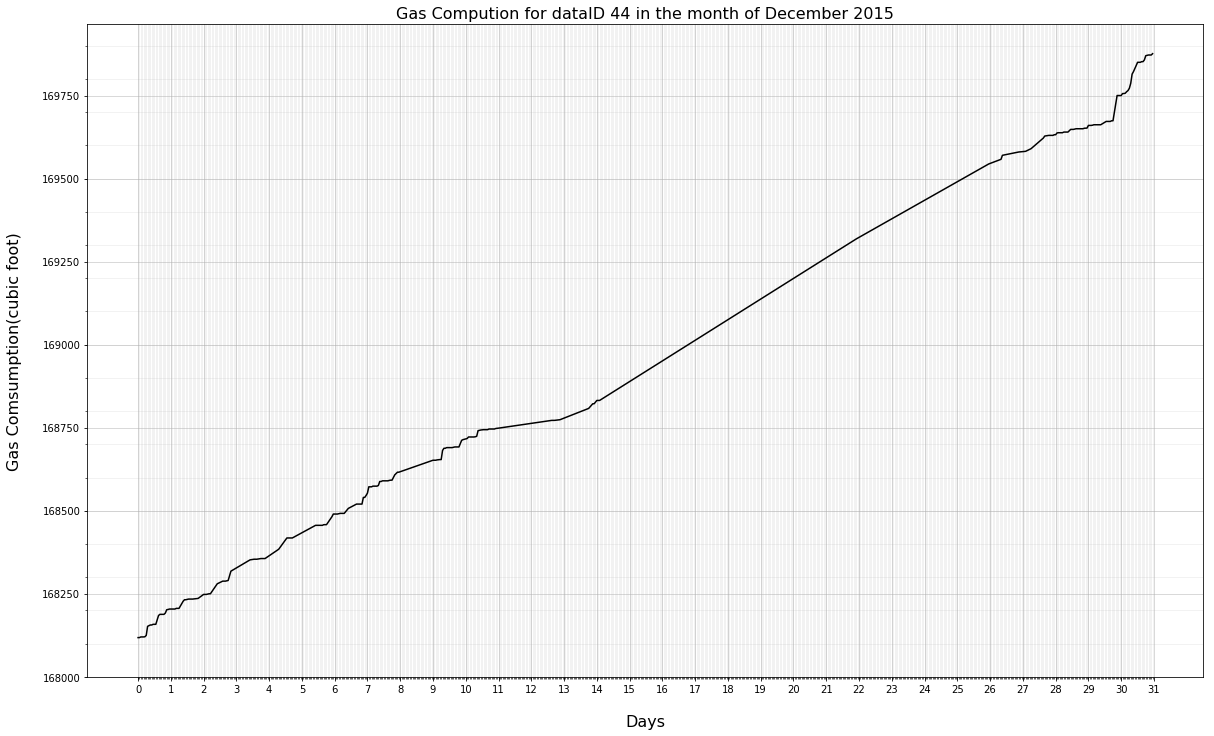

In [21]:
# Might take a long time if u run the scatter and the line plot
# df_plot = filter_dataframe(df_modify_interpolated,4874,2015,10)
# list_no_malfunction


# Plotting only one graph to save space
# for i in list_no_malfunction:
for i in [44]:
    df_plot_interpolated = filter_dataframe(df_modify_interpolated,i,2015,12)
    df_plot_not_interpolated = filter_dataframe(df_modify_not_interpolated,i,2015,12)
    meter_value_interpolated = df_plot_interpolated['meter_value'].values
    meter_value_not_interpolated = df_plot_not_interpolated['meter_value'].values

    fig = plt.figure(figsize=(20,12))
    ax1 = fig.add_subplot(111)

    # Setting x-axis
    major_ticks = np.arange(0,745,24)
    minor_ticks = np.arange(0,744,1)
    labels = np.arange(0,32,1)
    
    ax1.set_xticks(major_ticks)
    ax1.set_xticks(minor_ticks,minor=True)
    ax1.set_xticklabels(labels)
    ax1.grid(which='major',alpha=0.6)
    ax1.grid(which='minor',alpha=0.2)
    
    #Plot from the df
    ax1.plot(meter_value_interpolated,color='black')
#     ax1.scatter(minor_ticks,meter_value_not_interpolated,s=2,color='red')
    
    # Setting y-axis
    y_ticks = ax1.get_yticks()
    y_minor_ticks = np.arange(min(y_ticks),max(y_ticks),100)
    ax1.set_yticks(y_minor_ticks,minor=True)

    ax1.set_xlabel("Days",labelpad=20,fontsize=16)
    ax1.set_ylabel("Gas Comsumption(cubic foot)",labelpad=20,fontsize=16)
    plt.title("Gas Compution for dataID {} in the month of December 2015".format(i), fontsize=16)
#     plt.margins(x=0)
#     plt.autoscale(tight=True)

    plt.show()

**1.3. Intuitively, we expect that gas consumption from diﬀerent homes to be correlated. For example, many homes would experience higher consumption levels in the evening when meals are cooked. For each home, ﬁnd the top ﬁve homes with which it shows the highest correlation.**

For this section, we will be using interpolated data for the month of December to find the correlation between each individual houses. 

By using a for loop, we can iterate through all the permutations to attain the respective correlation values. After, the output is then saved into a matrix to determine the top 5 correlation values for each individual house ID.

In [22]:
df_modify_interpolated_december = df_modify_interpolated[(df_modify_interpolated['Year'] == 2015) & (df_modify_interpolated['Month'] == 12)]
df_modify_interpolated_december.sample(5)

,Year,Month,Day,Hour,meter_value,dataid
1648,2015,12,8,16,268136.666667,5484
1672,2015,12,9,16,222450.000000,4352
1818,2015,12,15,18,99411.419355,6685
1806,2015,12,15,6,224607.333333,2470
1537,2015,12,4,1,288037.000000,5972


In [23]:
print(df_modify_interpolated_december['dataid'].unique())

[ 739 6910 3635 4352 1714 9849 6412 7429  871 1589 9631 4447 2034 5275
 7287 4296  252 8829 3039 9121 7741 7919 7674 4732  370 9295 3577  222
 1697 4767 5785 3367 8467 5972 5439  114 9474 7460 9278 2018 9052 9956
 8155 5636 4029 1791 9729 1283 1792 7682 2638  187 3723 1619 4421  661
 4373 5484 2072 2461  744 1800 2980 2094 7900 8084 3849 4356 2965 2575
 8086 1415 2233 6863 2470 3778 2378 6830 9766 8703 6578 4228 2645 6505
 5395 8059 7965   44 4671 6685 2945 2818 7016 8967 3310 3918 8386 1103
 9620 5658 5545 5317 3036 9160 8244 2755 9600 2946 1403 7566 6673 2814
 6101 4874]


In [24]:
# Create a matrix to store the correlation between each house
num_house = len(list_no_malfunction)
corr = np.zeros((num_house,num_house))

# Loop through each of the data 
# Calculate the correlation
# Store the data into the matrix
for i in range(0,num_house):
    for j in range(0,num_house):
        data_id_i = list_no_malfunction[i]
        data_id_j = list_no_malfunction[j]
#         print("Correlating dataID {} and {}".format(data_id_i,data_id_j))
        df_i = df_modify_interpolated_december[(df_modify_interpolated_december['dataid'] == data_id_i)]
        df_j = df_modify_interpolated_december[(df_modify_interpolated_december['dataid'] == data_id_j)]
        meter_value_i = df_i['meter_value'].values
        meter_value_j = df_j['meter_value'].values
#         print(meter_value_i.shape)
#         print(meter_value_j.shape)
        correlation = np.corrcoef(meter_value_i,meter_value_j)
        corr[i][j] = correlation[0,1]

In [25]:
corr = np.nan_to_num(corr)
corr

array([[1.        , 0.99249991, 0.98713431, ..., 0.        , 0.        ,
        0.        ],
       [0.99249991, 1.        , 0.98707167, ..., 0.        , 0.        ,
        0.        ],
       [0.98713431, 0.98707167, 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [26]:
top_5 = []
n = 1

for i in range(0,num_house):
    top_5_position = corr[i].argsort()[-6:][::-1] #Taking the top 6 in case the top value is the same position as i
    for j in top_5_position:
        top_5.append(corr[i][j])
    if all(v == 0 for v in top_5):
        print("There is no correlation for dataID {}".format(list_no_malfunction[i]))
    else:
        print("The top 5 correlated value for house with dataID {}:".format(list_no_malfunction[i]))
        for j in top_5_position:
            if i != j:
                if n <= 5:
                    print("{}) dataID: {} , correlation value: {:2f}".format(n,list_no_malfunction[j],corr[i][j]))
                    n=n+1

    n = 1
    top_5 = []# Clean array for the next itteration
    print()

The top 5 correlated value for house with dataID 739:
1) dataID: 9295 , correlation value: 0.998650
2) dataID: 2965 , correlation value: 0.997557
3) dataID: 7287 , correlation value: 0.997451
4) dataID: 4373 , correlation value: 0.996668
5) dataID: 8155 , correlation value: 0.996437

The top 5 correlated value for house with dataID 6910:
1) dataID: 7429 , correlation value: 0.997876
2) dataID: 871 , correlation value: 0.997730
3) dataID: 2034 , correlation value: 0.997320
4) dataID: 5785 , correlation value: 0.996838
5) dataID: 9729 , correlation value: 0.996802

The top 5 correlated value for house with dataID 3635:
1) dataID: 744 , correlation value: 0.997987
2) dataID: 9121 , correlation value: 0.996548
3) dataID: 5484 , correlation value: 0.996294
4) dataID: 1415 , correlation value: 0.996159
5) dataID: 9766 , correlation value: 0.996104

The top 5 correlated value for house with dataID 4352:
1) dataID: 2638 , correlation value: 0.999639
2) dataID: 9474 , correlation value: 0.99853

**1.4 In Question 2 below, you will have to analyze the data further. In addition to what you are asked to do below, please propose additional analysis you can do with the data. Justify why you would carry out the analysis. If you give us your suggestions at the Interim, we will give you feedback.**

#### Predictive analysis: Predict activites based on the meter_value data, using unsupervised machine learning/statistics to perform classification of the data 

1. Use analysis to determine periods where there is increased usage (i.e. night time - cooking) to regulate pricing; pricing differs according to different usage periods. This data can be used to introduce competitions into the field; more competition, more likely for price moderation.
    - We will set an initial pricing scheme with reference from the U.S. Energy Information Administration.
    - After determining periods of increased usage, the pricing scheme will be revised.
    
2. Use machine learning to predict when will the meters would likely malfunction. This allows for timely rectification before the meter malfunctions; predictive maintenance. This approach complements the "end of usage" definition by manufacturers.
    - Define clearly what is malfunction; this gives us labels to work with.
    - Define the actual threshold of malfunction.

## 2. Forecasting (20 pts)

**2.1 In this part, you will asked to build a model to forecast the hourly readings in the future (next hour). Can you explain why you may want to forecast the gas consumption in the future? Who would ﬁnd this information valuable? What can you do if you have a good forecasting model?**

Forecasting hourly gas consumption can show usage trends which can benefit companies and the environment. This is because the forecasted data offers deep insights on usage which can be used to optimise pricing in reference to supply and demand of natural resources.

Benefits of forecasting future gas consumption,
1. Management of natural resources
    - Offers better insights on usage trends which can help regulate pricing at different timings
    - Contributes to the efforts of saving the environment

2. Introduces competitions to the market
    - Provides insights on usage that advises gas companies in the market for competitive pricing moderation
    - Prices can be adjusted based on supply and demand

3. Detection of potential malfunctioning meters
    - If forecasted graphs appears as a y=x slope, there is a likelihood of malfunctioning; y=x can possibly indicate a lack of or inconsistent data.
    - Appropriate criterias such as number of data points, span of time can be taken into account and an machine learning algorithm can be created to output malfunction likelihood.
    - Presents potential revenue loss for gas companies

In a nutshell, forecasting hourly usage of gas consumption can show usage trends and provides better insights to gas companies for the purpose of predicting consumption rates for pricing optimisation. In addition, a good forecasting model would be a good foundation for additional analysis such as detection of potential malfunctioning meters.

**2.2 Build a linear regression model to forecast the hourly readings in the future (next hour). Generate two plots: (i) Time series plot of the actual and predicted hourly meter readings and (ii) Scatter plot of actual vs predicted meter readings (along with the line showing how good the ﬁt is).**

For linear regression, we will be using the batch of data ID that does not have any malfunction readings.

In [27]:
print(sorted(list_no_malfunction))

[44, 114, 187, 222, 252, 370, 661, 739, 744, 871, 1103, 1283, 1403, 1415, 1589, 1619, 1697, 1714, 1791, 1792, 1800, 2018, 2034, 2072, 2094, 2233, 2378, 2461, 2470, 2575, 2638, 2645, 2755, 2814, 2818, 2945, 2946, 2965, 2980, 3036, 3039, 3310, 3367, 3577, 3635, 3723, 3778, 3849, 3918, 4029, 4228, 4296, 4352, 4356, 4373, 4421, 4447, 4671, 4732, 4767, 4874, 5275, 5317, 5395, 5439, 5484, 5545, 5636, 5658, 5785, 5972, 6101, 6412, 6505, 6578, 6673, 6685, 6830, 6863, 6910, 7016, 7287, 7429, 7460, 7566, 7674, 7682, 7741, 7900, 7919, 7965, 8059, 8084, 8086, 8155, 8244, 8386, 8467, 8703, 8829, 8967, 9052, 9121, 9160, 9278, 9295, 9474, 9600, 9620, 9631, 9729, 9766, 9849, 9956]


From the list shown above, data ID number 44 will be used as a sample to answer 2.2 and 2.3.

We will first obtain the raw data for data ID 44.

In [28]:
df_modify_dataid44 = df_modify_2[df_modify_2['dataid'] == 44]
df_modify_dataid44 = df_modify_dataid44.sort_values(by=['dataid','Year','Month','Day','Hour']) ## Sort the value from earlist to latest
df_modify_dataid44.head()

,dataid,Year,Month,Day,Hour,meter_value
4087,44,2015,10,12,18,165674.0
4088,44,2015,10,12,19,165674.0
4089,44,2015,10,12,21,165684.0
4090,44,2015,10,12,23,165686.0
4091,44,2015,10,13,0,165686.0


Since time is separated into year, month, day and hour, it is difficult to find a common axis to do linear regression on. Our solution is to convert time into hourly intervals from the starting entry of the data collection to the last entry of the data collection. Thereafter, we will be implementing two functions as shown below to help us convert the time into hourly intervals and vice versa.

In [29]:
def convert_date_hour_to_interval(x):
    start_time = datetime.datetime(2015,10,1,0) # First Record of data is on 2015-10-1 0 hour
    end_time = datetime.datetime(int(x[1]),int(x[2]),int(x[3]),int(x[4]))
    hours_difference = abs(start_time - end_time).total_seconds() / 3600.0
    return int(hours_difference)

def convert_interval_to_date_hour(interval):
    start_time = datetime.datetime(2015,10,1,0) # First Record of data is on 2015-10-1 0 hour
    difference = datetime.timedelta(hours=interval)
    end_time = start_time + difference
    return end_time

The next step would be to implement the function to our dataframe and creates a new column for hourly intervals.

In [30]:
df_modify_dataid44['Interval'] = df_modify_dataid44.apply(convert_date_hour_to_interval,axis=1)
df_modify_dataid44.head()

,dataid,Year,Month,Day,Hour,meter_value,Interval
4087,44,2015,10,12,18,165674.0,282
4088,44,2015,10,12,19,165674.0,283
4089,44,2015,10,12,21,165684.0,285
4090,44,2015,10,12,23,165686.0,287
4091,44,2015,10,13,0,165686.0,288


Before splitting the dataset into training and testing sets, we want to find out how much raw data are there for data ID 44.

In [31]:
df_modify_dataid44.shape

(738, 7)

From the results above, we can see that there are 738 raw data for data ID 44. Now, let's split the raw dataset into training and test sets respectively. As a rule of thumb, we would use 70% of the data for **training** and the remaining 30% for **testing**; this 70/30 distribution is a standard practice for machine learning. We will also print out the **SIZE** of the test and training set at the end to verify the 70/30 distribution (split).

In [32]:
x = df_modify_dataid44['Interval'].values
x = x.reshape(-1, 1)
print("The size for x dataset: {}".format(x.shape))
y = df_modify_dataid44['meter_value'].values
y = y.reshape(-1,1)
print("The size for y dataset: {}".format(y.shape))

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.3)
print('Size for Training set for X: {}'.format(x_train.shape))
print('Size for Training set for y: {}'.format(y_train.shape))
print('Size for Test set for X: {}'.format(x_test.shape))
print('Size for Test set for y: {}'.format(y_test.shape))

The size for x dataset: (738, 1)
The size for y dataset: (738, 1)
Size for Training set for X: (516, 1)
Size for Training set for y: (516, 1)
Size for Test set for X: (222, 1)
Size for Test set for y: (222, 1)


To perform the linear regresion, we will use the linear regression function from scikit_learn.

In [33]:
lr = LinearRegression()
lr.fit(x_train,y_train)

y_train_predict = lr.predict(x_train)
print('Size for Prediction value for training set: {}'.format(y_train_predict.shape))

y_test_predict = lr.predict(x_test)
print('Size for Prediction value for test set: {}'.format(y_test_predict.shape))

Size for Prediction value for training set: (516, 1)
Size for Prediction value for test set: (222, 1)


Below are the details for the linear regression and the mean squre error of the data for data ID 44.

In [34]:
y_intercept = lr.intercept_
gradient = lr.coef_

print("The gradient of the best fit line is {0:,.2f}".format(gradient[0][0]))
print("The y-intercept of the best fit line is {0:,.2f}".format(y_intercept[0]))

mse_train = mean_squared_error(y_train, y_train_predict)
print("The mean-square error of the train data set is {0:,.2f}".format(mse_train))

mse_test = mean_squared_error(y_test, y_test_predict)
print("The mean-square error of the test data set is {0:,.2f}".format(mse_test))

The gradient of the best fit line is 2.78
The y-intercept of the best fit line is 164,167.00
The mean-square error of the train data set is 90,072.48
The mean-square error of the test data set is 80,626.48


For visualisation, we will plot 3 different graphs that shows:  
1. Original plot of the data
2. Training data and the linear regression
3. Test data and the linear regression

Text(0,0.5,'Meter Reading')

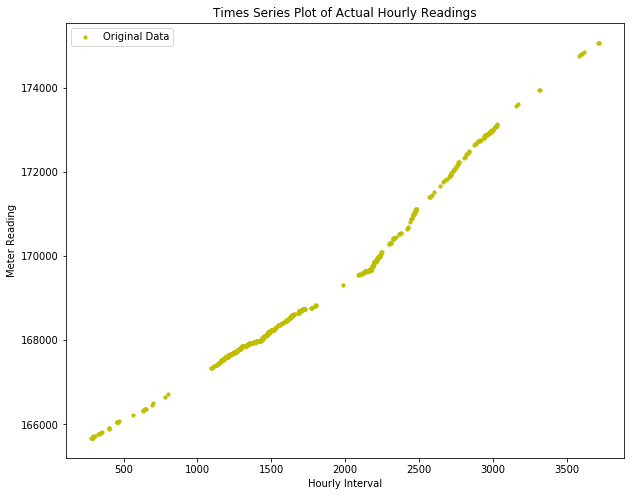

In [35]:
## Original data

f, ax = plt.subplots(1, 1,figsize=(10,8))
ax.scatter(x,y,s=10, c='y', marker='o', label='Original Data')
ax.legend(loc='upper left')
ax.set_title("Times Series Plot of Actual Hourly Readings")
ax.set_xlabel("Hourly Interval")
ax.set_ylabel("Meter Reading")

Text(0,0.5,'Meter Reading')

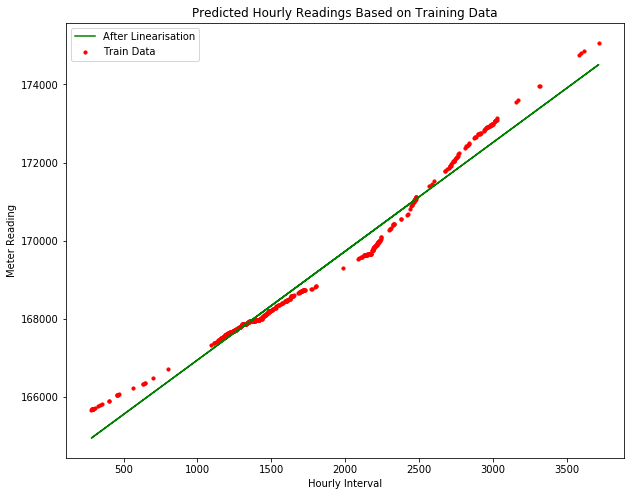

In [36]:
## Training data and Linear regression

f, ax = plt.subplots(1, 1,figsize=(10,8))
ax.scatter(x_train,y_train,s=10, c='r', marker='o', label='Train Data')
ax.plot(x_train,y_train_predict,'g', label='After Linearisation')
ax.legend(loc='upper left')
ax.set_title("Predicted Hourly Readings Based on Training Data")
ax.set_xlabel("Hourly Interval")
ax.set_ylabel("Meter Reading")

Text(0,0.5,'Meter Reading')

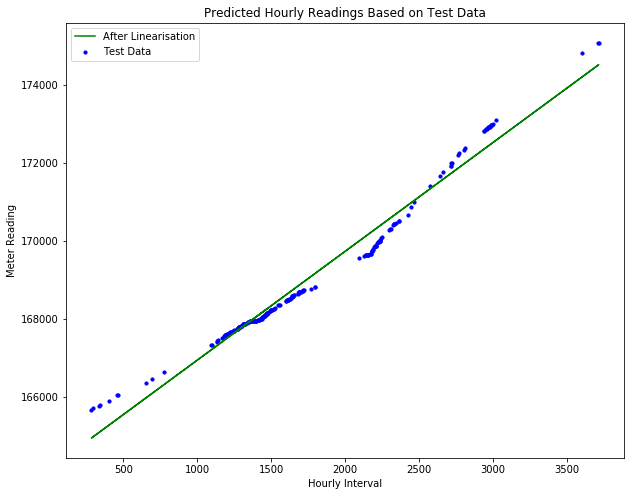

In [37]:
## Test data and Linear regression

f, ax = plt.subplots(1, 1,figsize=(10,8))
ax.scatter(x_test,y_test,s=10, c='b', marker='o', label='Test Data')
ax.plot(x_test,y_test_predict,'g', label='After Linearisation')
ax.legend(loc='upper left');
ax.set_title("Predicted Hourly Readings Based on Test Data")
ax.set_xlabel("Hourly Interval")
ax.set_ylabel("Meter Reading")

**2.3 Do the same as Question 2.2 above but use support vector regression (SVR).**

For this part, we will be doing support vector regression (SVR) using linear kernel. For the training and test, we would be using the same training and test data as shown in question 2.2.

#### Support Vector Regression (SVR): Linear Kernel

In [38]:
svr_lin = SVR(kernel='linear')
svr_lin.fit(x_train,y_train.ravel())

y_train_predict = svr_lin.predict(x_train)
print('Size for Prediction value for training set: {}'.format(y_train_predict.shape))

y_test_predict = svr_lin.predict(x_test)
print('Size for Prediction value for test set: {}'.format(y_test_predict.shape))

Size for Prediction value for training set: (516,)
Size for Prediction value for test set: (222,)


In [39]:
mse_train = mean_squared_error(y_train, y_train_predict)
print("The mean-square error of the train data set is {0:,.2f}".format(mse_train))

mse_test = mean_squared_error(y_test, y_test_predict)
print("The mean-square error of the test data set is {0:,.2f}".format(mse_test))

The mean-square error of the train data set is 90,715.61
The mean-square error of the test data set is 79,760.32


Text(0,0.5,'Meter Reading')

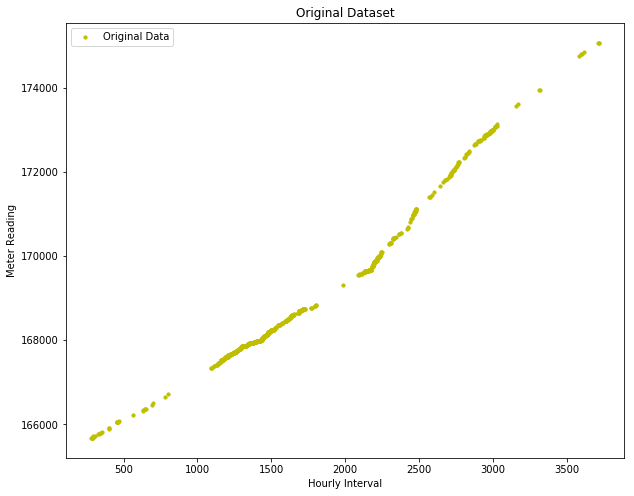

In [40]:
## Original data

f, ax = plt.subplots(1, 1,figsize=(10,8))
ax.scatter(x,y,s=10, c='y', marker='o', label='Original Data')
ax.legend(loc='upper left')
ax.set_title("Original Dataset")
ax.set_xlabel("Hourly Interval")
ax.set_ylabel("Meter Reading")

Text(0,0.5,'Meter Reading')

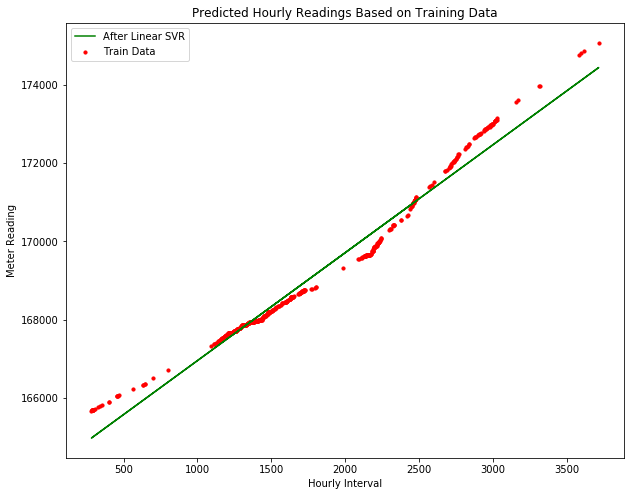

In [41]:
## Training data and Linear regression

f, ax = plt.subplots(1, 1,figsize=(10,8))
ax.scatter(x_train,y_train,s=10, c='r', marker='o', label='Train Data')
ax.plot(x_train,y_train_predict,'g', label='After Linear SVR')
ax.legend(loc='upper left')
ax.set_title("Predicted Hourly Readings Based on Training Data")
ax.set_xlabel("Hourly Interval")
ax.set_ylabel("Meter Reading")

Text(0,0.5,'Meter Reading')

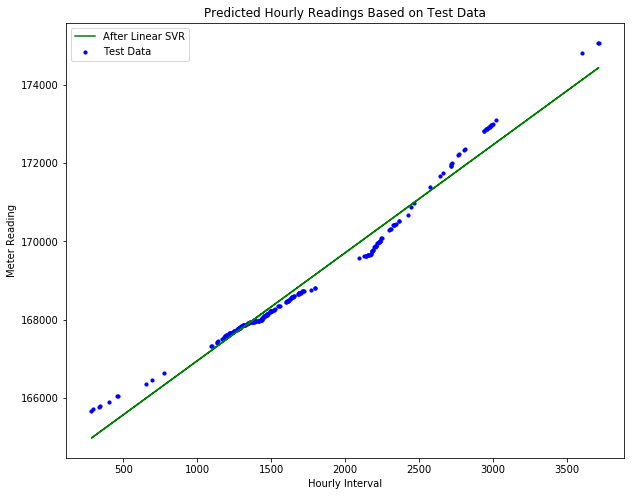

In [42]:
## Test data and Linear regression

f, ax = plt.subplots(1, 1,figsize=(10,8))
ax.scatter(x_test,y_test,s=10, c='b', marker='o', label='Test Data')
ax.plot(x_test,y_test_predict,'g', label='After Linear SVR')
ax.legend(loc='upper left');
ax.set_title("Predicted Hourly Readings Based on Test Data")
ax.set_xlabel("Hourly Interval")
ax.set_ylabel("Meter Reading")

## 3. Student Proposal (10 pts)

**3.1 At this point, you understand the data quite well. Propose and carry out additional analysis using the dataset given. Please be sure to justify why this additional analysis is useful and interesting.**

### Part 1: Insights for regulation of supply and demand for the gas industry

First, we will like to get a better general understanding of the data. Our objective for this first step is to calculate the difference in gas consumption for every hour in the data. We will be implementing a dataframe to store all the values of this difference. For faster execution, we will then save this dataframe into a csv file and read from it whenever we run this program. 

The assumption for this analysis is that interpolated data represents the actual gas consumption of each household for the entire duration of the data (October 2015 - March 2016). This is because within the raw data, there are several missing meter readings at certain hours.

Our second assumption is that gas is only used for both cooking and heating in the household. This would shape our hypothesis as we intend to test this assumption by visualising the data out using heatmaps.

We will be removing the data ID which has malfunction as to not affect our results. (Definition of malfunction: previous reading > current reading)

In [43]:
df_difference_interpolated = pd.DataFrame(np.zeros((5,10)),columns=['dataid','Difference','Previous Year','Previous Month','Previous Day', 'Previous Hour','Current Year','Current Month','Current Day','Current Hour'])
df_difference_interpolated

,dataid,Difference,Previous Year,Previous Month,Previous Day,Previous Hour,Current Year,Current Month,Current Day,Current Hour
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
## Brute force approach to find the difference in meter reading for the non-malfunction dataID

def find_difference(df,df_malfunction):
    temp_list = []
    list_1 = df['dataid'].unique()
    previous_meter = 0
    previous_year = 0
    previous_month = 0
    previous_day = 0
    previous_hour = 0

    current_meter = 0
    current_year = 0
    current_month = 0
    current_day = 0
    current_hour = 0
    difference = 0

    n = 0
    progress = 1

    for i in list_1:
        print("Currently processing dataid: {}".format(i))
        print("Process level : {}/{}".format(progress,len(list_1)))
        progress = progress + 1
        df_temp = df[df['dataid'] == i].reset_index()
        for index, row in df_temp.iterrows():
            if index == 0:
                previous_meter = row['meter_value']
                previous_year = row['Year']
                previous_month = row['Month']
                previous_day = row['Day']
                previous_hour = row['Hour']
            else:
                current_meter = row['meter_value']
                current_year = row['Year']
                current_month = row['Month']
                current_day = row['Day']
                current_hour = row['Hour']
                difference = current_meter - previous_meter 
                temp_list.append(i)
                temp_list.append(difference)
                temp_list.append(previous_year)
                temp_list.append(previous_month)
                temp_list.append(previous_day)
                temp_list.append(previous_hour)
                temp_list.append(current_year)
                temp_list.append(current_month)
                temp_list.append(current_day)
                temp_list.append(current_hour)
   

                df_malfunction.loc[n] = temp_list
                n = n + 1
                temp_list.clear()

                previous_meter = row['meter_value']
                previous_year = row['Year']
                previous_month = row['Month']
                previous_day = row['Day']
                previous_hour = row['Hour']          

        previous_meter = 0
        previous_date = 0
        previous_hour = 0
        previous_minute = 0
        previous_second = 0

        current_meter = 0
        current_meter = 0
        current_date = 0
        current_hour = 0
        current_minute = 0
        current_second = 0

        difference = 0

# # Generating data for malfunction ##
# find_difference(df_modify_interpolated,df_difference_interpolated)
# df_difference_interpolated.to_csv('difference.csv',index=False)
# df_difference_interpolated.sample(5)

## Reading malfunction data from pre-saved CSV (for faster execution time) ##
# **drop the first coloumn as it contains the index of the dataframe**
df_difference_interpolated = pd.read_csv('difference.csv',sep=",",dtype={"dataid":int, "Previous Year":int, "Previous Month":int, "Previous Day":int,"Previous Hour":int,"Current Year":int,"Current Month":int,"Current Day":int,"Current Hour":int})
df_difference_interpolated.sample(5)

,dataid,Difference,Previous Year,Previous Month,Previous Day,Previous Hour,Current Year,Current Month,Current Day,Current Hour
245310,661,0.000000,2016,3,7,13,2016,3,7,14
289476,8084,2.000000,2016,3,18,5,2016,3,18,6
107231,370,2.000000,2015,12,16,23,2015,12,17,0
304511,2575,0.909091,2015,12,3,20,2015,12,3,21
238111,4421,0.500000,2015,11,11,13,2015,11,11,14


The next step will be to visualise the data for a particular month and plot the difference in consumption for every hour for every day in the month. We will be plotting a heatmap for every month to show the different consumption value for each day and each hour. Our hypothesis is that for certain days and hours, there will be a higher consumption levels as compared to different days as it might be days where people cook for seasonal holidays.

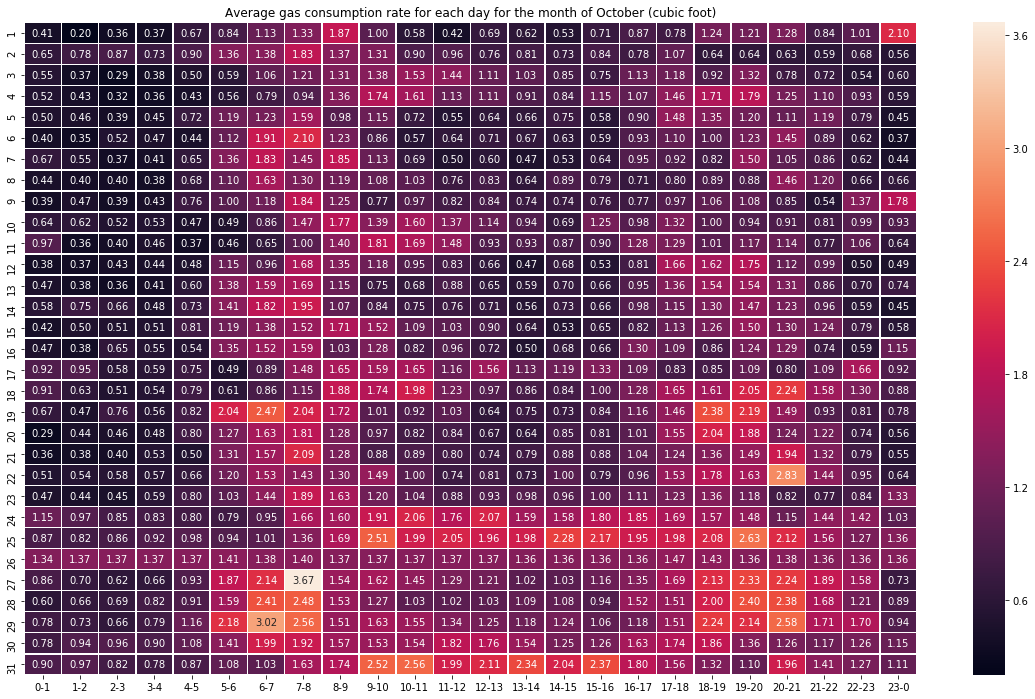

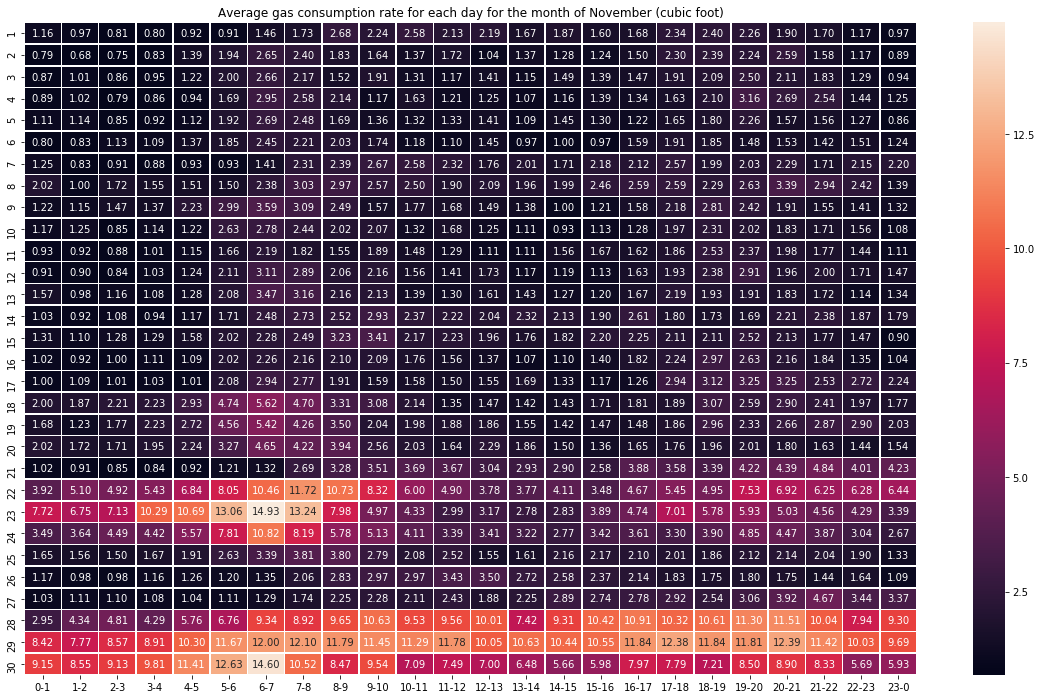

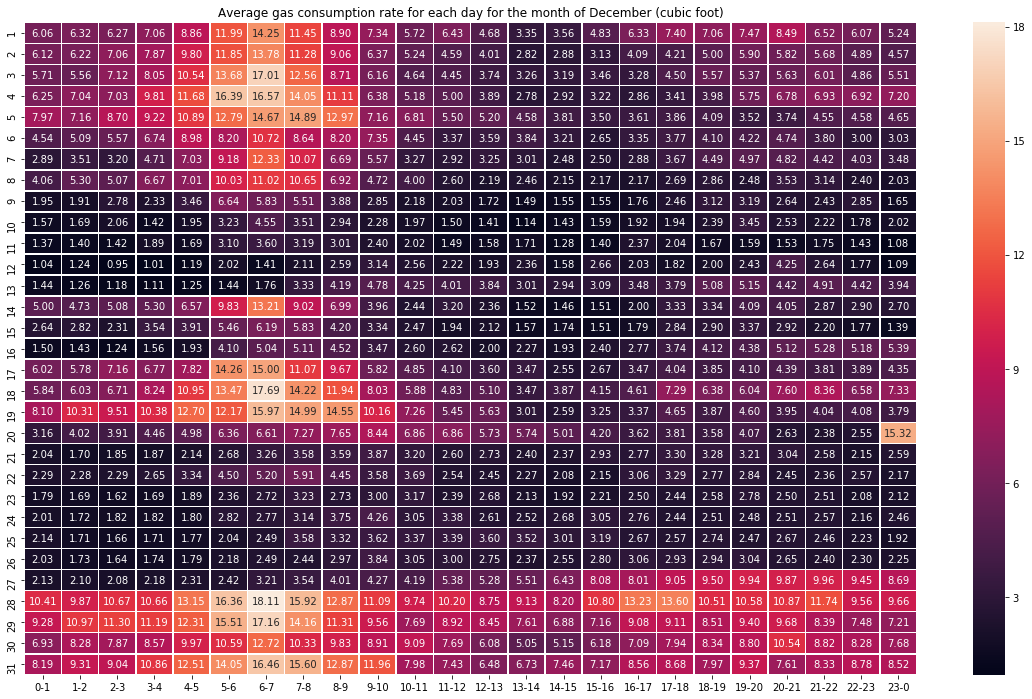

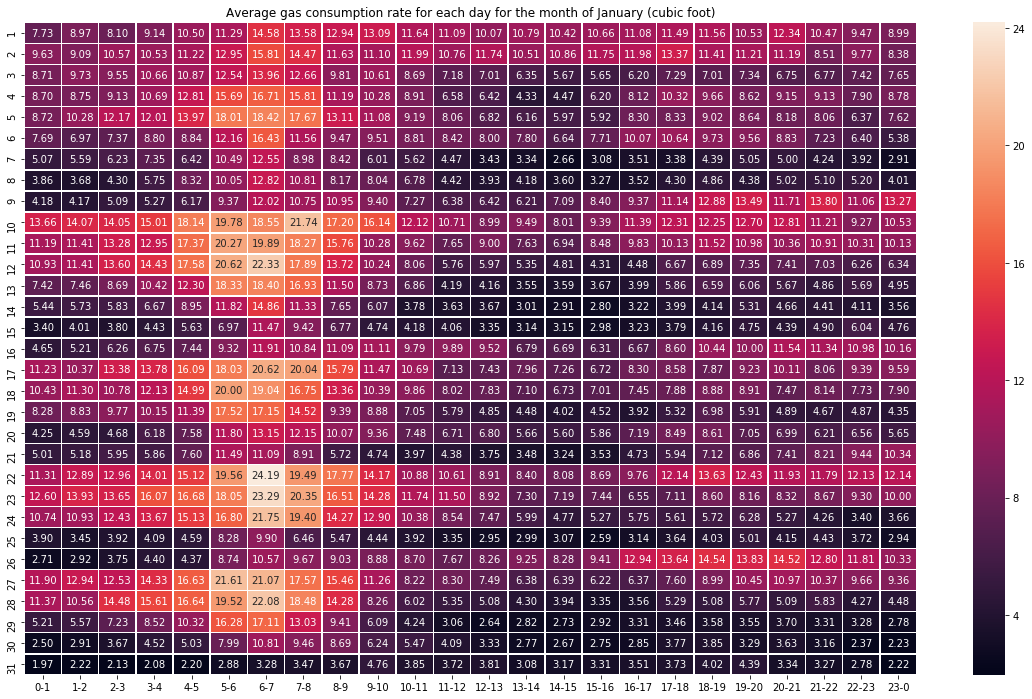

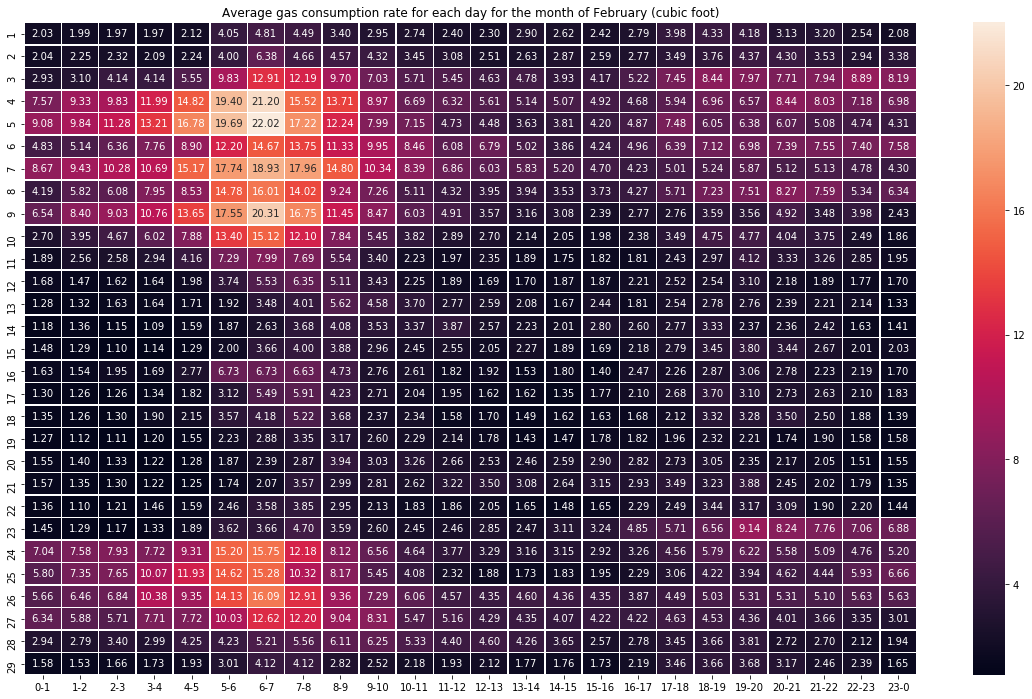

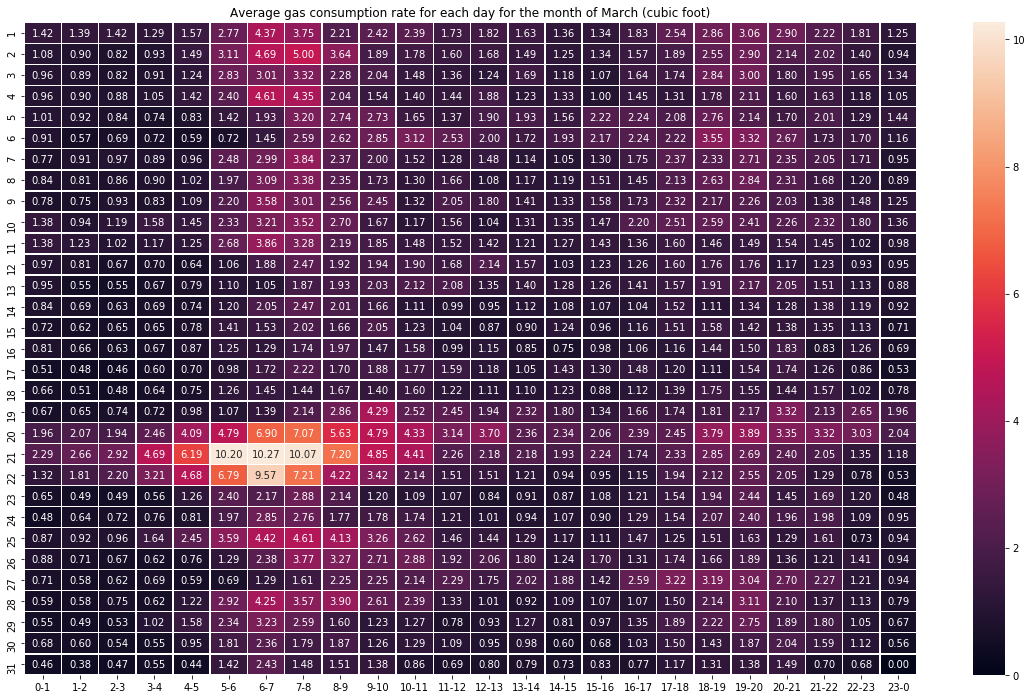

In [45]:
# To illustrate the average gas consumption increase for every hour per day for a particular month
# Plot all consumption level for month of October for each day

names_months = ['January','February','March','April','May','June','July','August','September','October','November','December']

## Itterate for all the months
for i in [10,11,12,1,2,3]:
    df_month = df_difference_interpolated[df_difference_interpolated['Previous Month'] == i]
    list_day = df_month['Previous Day'].unique()
    
    # Create a heatmap array to store the consumption rates for every day for that month
    heatmap_array = np.zeros((len(list_day),24))
    
    n = 0

    for day in list_day:
        df_temp = df_month[df_month["Previous Day"] == day]
        df_temp = df_temp.drop(columns=['dataid','Previous Year','Previous Month','Previous Day','Current Year','Current Month','Current Day'])
        df_temp = df_temp.groupby(['Previous Hour', 'Current Hour']).mean().reset_index()
        df_temp['Interval'] = df_temp.apply(lambda x: str(int(x[0])) + '-' + str(int(x[1])), axis = 1)
        df_temp = df_temp.drop(columns=['Previous Hour','Current Hour'])
        if i == 3:
            temp = df_temp['Difference'].values
            if temp.shape == (23,):
                temp = np.append(temp, 0)
            heatmap_array[n,:] = temp
        else:
            heatmap_array[n,:] = df_temp['Difference'].values 
        n = n + 1

    if i == 10:
        heatmap_xlabels = df_temp['Interval'].values
    heatmap_ylabels = list_day.copy()

    fig, ax = plt.subplots(figsize=(20,12))
    ax = sns.heatmap(heatmap_array, linewidth=0.5,xticklabels=heatmap_xlabels,yticklabels=heatmap_ylabels,annot=True, fmt=".2f")
    plt.title("Average gas consumption rate for each day for the month of {} (cubic foot)".format(names_months[i-1]))
    plt.show()

The days on which there should be a higher consumption of gas are the following:  
1. Eve of Thanksgiving or Thanksgiving itself: 25-26 Nov 2015
2. Eve of Christmas or Christmas itself: 24-25 Dec 2015

However, we realise that this is not the case as the consumption rate is relatively low during those days. Infering from this result, we can see that this household could be comprised of younger families which they might go back to their parent's home for Thanksgiving and Christmas celebrations. 

The plot above helps in the visualisation of the consumption for every hour for every day in that particular month. However, it is difficult to compare this data with another month as there are too many plots. To get a deeper insight of how the gas consumption differs for each month, we averaged the gas consumption for a particular hour in the month. We will then create a heatmap to use the colour visualisation to see at which hour and which month has the highest or lowest gas consumption.

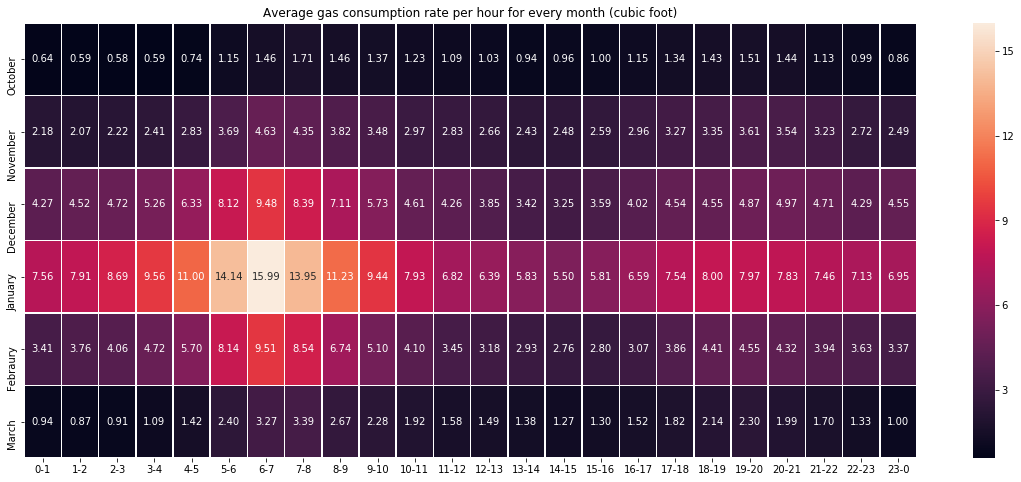

In [46]:
# Create a heatmap array to store the consumption rates for every month
heatmap_array_gas = np.zeros((6,24))

n = 0

for i in [10,11,12,1,2,3]:
    df_temp = df_difference_interpolated[df_difference_interpolated['Previous Month'] == i]
    df_temp = df_temp.drop(columns=['dataid','Previous Year','Previous Month','Previous Day','Current Year','Current Month','Current Day'])
    df_temp = df_temp.groupby(['Previous Hour', 'Current Hour']).mean().reset_index()
    df_temp['Interval'] = df_temp.apply(lambda x: str(int(x[0])) + '-' + str(int(x[1])), axis = 1)
    df_temp = df_temp.drop(columns=['Previous Hour','Current Hour'])
    heatmap_array_gas[n,:] = df_temp['Difference'].values
    n = n + 1
    
heatmap_xlabels = df_temp['Interval'].values
    
fig, ax = plt.subplots(figsize=(20,8))
ax = sns.heatmap(heatmap_array_gas, linewidth=0.5,xticklabels=heatmap_xlabels,yticklabels=['October','November','December','January','Febraury','March'],annot=True, fmt=".2f")
plt.title("Average gas consumption rate per hour for every month (cubic foot)")
plt.show()

From the plot above, we could see that for the month of January, the consumption of gas is the highest as compared to the other months. The probable reason could be that during that month, the temperature is very cold and more gas is being consumed to warm the house. To test our hypothesis, we extract temperature data from October 2015 - March 2016 for comparison. The data is webscrapped from the website www.timeanddate.com. The webscrapping code is available in a seperate ipython notebook anbd the data is save to a csv file called temperature.csv

In [47]:
df_temperature = pd.read_csv('temperature.csv',sep=",",dtype=int)
df_temperature.sample(5)

,Year,Month,Day,Hour,Temperature
8059,2016,8,31,19,33
2717,2016,1,22,5,7
7454,2016,8,6,14,36
2203,2015,12,31,19,11
6646,2016,7,3,22,29


We will be plotting a heatmap with similiar format as above, showing the average temperature reading for each intervals.

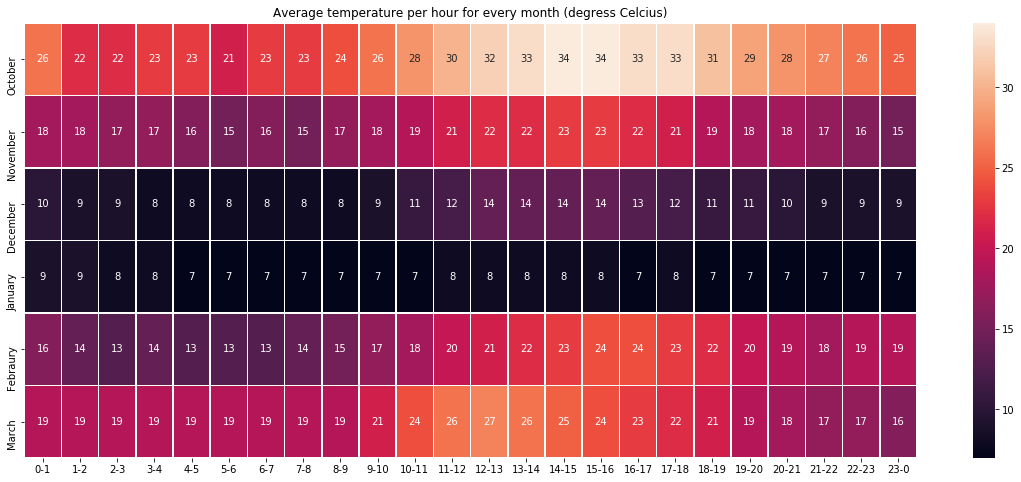

In [48]:
# Create a heatmap array to store the consumption rates for every month
heatmap_array_temperature = np.zeros((6,24))

n = 0

for i in [10,11,12,1,2,3]:
    df_temp = df_temperature[df_temperature['Month'] == i]
    df_temp = df_temp.drop(columns=['Year','Month','Day'])
    df_temp = df_temp.groupby(['Hour']).mean().reset_index()
    heatmap_array_temperature[n,:] = df_temp['Temperature'].values.astype(int)
    n = n + 1
    
fig, ax = plt.subplots(figsize=(20,8))
ax = sns.heatmap(heatmap_array_temperature, linewidth=0.5,xticklabels=heatmap_xlabels,yticklabels=['October','November','December','January','Febraury','March'],annot=True)
plt.title("Average temperature per hour for every month (degress Celcius)")
plt.show()

Now, a machine learning algorithm is used here to predict the likely meter_reading consumption for the month of April to August 2016. This allows us grasp an idea of the gas consumption within a year in order to balance the demand and supply accordingly. 

Before the algorithm runs, the data is arranged into a dataframe table. This allows us to split the data easily into training and testing sets where ratio for training and testing would be 80% (Training) 20% (Testing).

In [49]:
# Sort out the required temperatures
df_temp = df_temperature[:4391]

df_ML = df_difference_interpolated.copy()
df_ML = df_ML.groupby(['Previous Year','Previous Month','Previous Day','Previous Hour','Current Year','Current Month','Current Day','Current Hour']).mean().reset_index()
df_ML = df_ML.drop(columns=['dataid','Current Year','Current Month','Current Day','Current Hour'])
df_ML = df_ML.rename(columns={'Previous Year': 'Year', 'Previous Month': 'Month', 'Previous Hour': 'Hour','Previous Day': 'Day'})
df_ML = pd.merge(df_ML, df_temp, on=['Year','Month','Day','Hour'])
print(df_ML.shape)
df_ML.sample(5)

(4391, 6)


,Year,Month,Day,Hour,Difference,Temperature
270,2015,10,12,6,0.962057,23
3129,2016,2,8,9,7.255188,17
1304,2015,11,24,8,5.781548,17
527,2015,10,22,23,0.639135,25
243,2015,10,11,3,0.460960,23


Training Set

In [50]:
trainingSet, testSet = train_test_split(df_ML, test_size=0.2)
print(trainingSet.shape)
trainingSet.head()

(3512, 6)


,Year,Month,Day,Hour,Difference,Temperature
3747,2016,3,5,3,0.742530,19
491,2015,10,21,11,0.797972,30
3018,2016,2,3,18,8.440679,22
1920,2015,12,20,0,3.155008,10
2417,2016,1,9,17,11.135998,8


Test Set

In [51]:
print(testSet.shape)
testSet.head()

(879, 6)


,Year,Month,Day,Hour,Difference,Temperature
1826,2015,12,16,2,1.240176,9
3750,2016,3,5,6,1.933942,19
1571,2015,12,5,11,5.495483,12
1565,2015,12,5,5,12.787067,8
46,2015,10,2,22,0.684695,26


Splting the X and Y variable for the training and test sets

In [52]:
X_train = trainingSet[['Year','Month','Day','Hour','Temperature']].values
Y_train = trainingSet.loc[:, ['Difference']].values
X_test = testSet.loc[:, ['Year','Month','Day','Hour','Temperature']].values
Y_test = testSet.loc[:, ['Difference']].values

print("Training set input sample")
print(X_train[0:3,:])
print(X_train.shape)
print()
print("Training set output sample")
print(Y_train[0:3,:])
print(Y_train.shape)
print()
print("Test set input sample")
print(X_test[0:3,:])
print(X_test.shape)
print()
print("Test set outputsample")
print(Y_test[0:3,:])
print(Y_test.shape)
print()

Training set input sample
[[2016    3    5    3   19]
 [2015   10   21   11   30]
 [2016    2    3   18   22]]
(3512, 5)

Training set output sample
[[0.7425303 ]
 [0.79797165]
 [8.44067936]]
(3512, 1)

Test set input sample
[[2015   12   16    2    9]
 [2016    3    5    6   19]
 [2015   12    5   11   12]]
(879, 5)

Test set outputsample
[[1.24017635]
 [1.9339416 ]
 [5.49548333]]
(879, 1)



For our machine learning model, we have decided to go with **linear regression with modification**. The difference in value will be change into a natural log scale. This is done because we realised that training without the log scale will give us negative value, which is not desired as gas consumption is supposed to be increasing and not decreasing. This could be avoided by converting the difference in value using the log scale. By implementing this, when the predicted value is negative, it means that the difference value is smaller than 0. 

We have also considered various different alogrithms such as regression and neural networks but have decided not to use them due to the following reason:

Regression Tree:  
* Values predicted are very discrete and does not reflect the trend that higher temperature leads to low consumption of gas.
    
Neural Network:
* The number of data that is available is quite small for a neural network to optimise its training (3512 x 5 = 17560 data).
* NN training takes a very long time and not ideal for older laptops.

### Linear Regression

In [53]:
## for show only, delete it if not need
print("Training set output sample")
print(Y_train[0:3,:])
print(Y_train.shape)
print()

temp = np.log(Y_train)
print("Training set output sample, log version")
print(temp[0:3,:])
print(temp.shape)
print()

Training set output sample
[[0.7425303 ]
 [0.79797165]
 [8.44067936]]
(3512, 1)

Training set output sample, log version
[[-0.2976916]
 [-0.2256822]
 [ 2.1330628]]
(3512, 1)



In [54]:
## Training Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(X_train, np.log(Y_train)) # Output is converted to log value before using it for training

## Prediction and findinf the results of the classifier
R2_score = lin_reg.score(X_test,np.log(Y_test)) # Compare with the log value of the output testset
Y_test_predict = np.exp(lin_reg.predict(X_test)) # Convert back the predicted value using exp
RMSE_score = mean_squared_error(Y_test, Y_test_predict)

print("The R2 score of the regression tree {0:.2f}".format(R2_score))
print("The RMSE score of the regression tree {0:.2f}".format(RMSE_score))

The R2 score of the regression tree 0.51
The RMSE score of the regression tree 10.70


With the machine learning training completed, we would like to use this model to predict the values of the future data.

### Create dataframe for future values

In [55]:
 # Creating a dataframe to store all the prediction for the future (April 2016 to September 2016)
temp_list = []

year = 2016
for month in [4,5,6,7,8,9]:
    if (month == 5) | (month == 7) | (month == 8):
        for day in range(1,32):
            for hour in range(0,24):
                temp_list.append([year,month,day,hour])   
    else:
        for day in range(1,31):
            for hour in range(0,24):
                temp_list.append([year,month,day,hour])  


temp_list = np.asarray(temp_list)
df_future = pd.DataFrame(temp_list,columns=['Year','Month','Day','Hour'])

df_temp = df_temperature.iloc[4392:-1]
df_future = pd.merge(df_future, df_temp, on=['Year','Month','Day','Hour'])
print(df_future.shape)
df_future.head(5)

(4391, 5)


,Year,Month,Day,Hour,Temperature
0,2016,4,1,0,19
1,2016,4,1,1,18
2,2016,4,1,2,17
3,2016,4,1,3,17
4,2016,4,1,4,17


### Predicting values using Linear Regression

In [56]:
## Predict the value for the certain row
future_X = df_future[['Year','Month','Day','Hour','Temperature']].values
future_Y = np.exp(lin_reg.predict(future_X).reshape(-1,1))
# print(future_Y)
df_future.loc[ : , 'Difference(LinReg)'] = future_Y

print(df_future.shape)
df_future.head(5)

(4391, 6)


,Year,Month,Day,Hour,Temperature,Difference(LinReg)
0,2016,4,1,0,19,1.559231
1,2016,4,1,1,18,1.716605
2,2016,4,1,2,17,1.889861
3,2016,4,1,3,17,1.914924
4,2016,4,1,4,17,1.940320


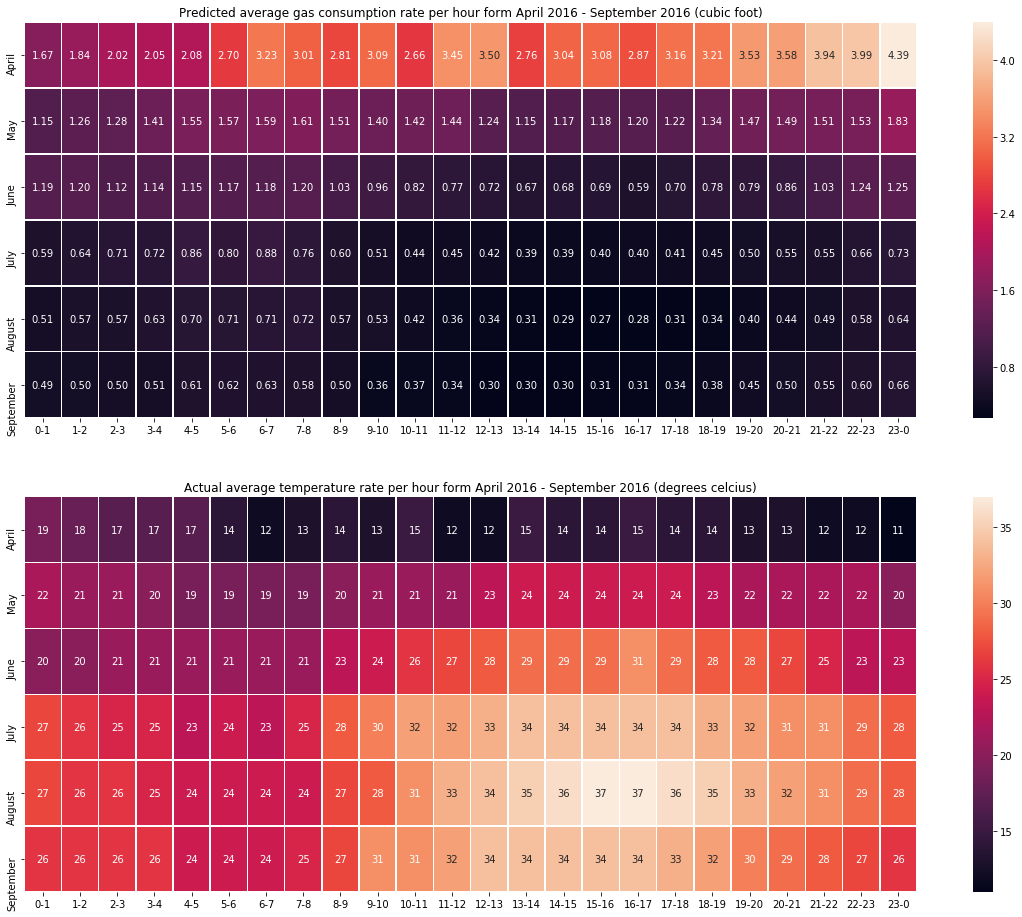

In [57]:
# Create a heatmap array to store the consumption rates for every month
# and display the temperature for each hour
heatmap_array_gas = np.zeros((6,24))
heatmap_array_temperature = np.zeros((6,24))
n = 0


for i in [4,5,6,7,8,9]:
    df_temp = df_future[df_future['Month'] == i]
    df_temp = df_temp.drop(columns=['Year','Month','Day'])
    df_temp = df_temp.groupby(['Hour']).mean().reset_index()
    heatmap_array_gas[n,:] = df_temp['Difference(LinReg)'].values
    heatmap_array_temperature[n,:] = df_temp['Temperature'].values
    n = n +1
    
heatmap_xlabels = ['0-1','1-2','2-3','3-4','4-5','5-6','6-7','7-8','8-9','9-10','10-11','11-12','12-13','13-14','14-15','15-16','16-17','17-18','18-19','19-20','20-21','21-22','22-23','23-0']
heatmap_ylabels = ['April','May','June','July','August','September']

fig, (ax1, ax2) = plt.subplots(2,1,figsize=(20,16))
sns.heatmap(heatmap_array_gas, linewidth=0.5,xticklabels=heatmap_xlabels,yticklabels=heatmap_ylabels,annot=True, fmt=".2f",ax=ax1)
ax1.set_title("Predicted average gas consumption rate per hour form April 2016 - September 2016 (cubic foot)")

sns.heatmap(heatmap_array_temperature, linewidth=0.5,xticklabels=heatmap_xlabels,yticklabels=heatmap_ylabels,annot=True,ax=ax2)
ax2.set_title("Actual average temperature rate per hour form April 2016 - September 2016 (degrees celcius)")
plt.show()

From the heatmaps above, it can be shown that the higher gas consumption periods occur during the months where the temperature is very cold (around 15 degrees or less) which coincides with the general idea that more heating is used during colder periods. From this information, gas companies can regulate gas pricing according to the data to manage supply and demand.

### Part 2: Predicting potential/malfunctioning meters for prompt maintenance.

For this part, we would like to use the raw data that we have detected for any malfunction to detect the severity of the malfunction. The notion is that gas companies can quickly detect how severe the malfunction is with the data that is received into the database. Depending on the severity of the malfunction,gas companies would be more informed on which meter to perform  earlier maintenance on.

Assumption: Malfunction is detected when previous meter reading is higher than current meter reading.

Before performing any machine learning to the data, it is modified such that every feature is classified as an integer (i.e. year,month,day,hour,minute,second) or float (difference in the meter reading) value.

In [58]:
df_malfunction.head()

,dataid,Previous meter,Current meter,Difference,Previous Date,Previous Hour,Previous Minute,Previous Second,Current Date,Current Hour,Current Minute,Current Second,Serverity
0,35,94014.0,94012.0,2.0,2015-10-20,8.0,53.0,16.0,2015-10-20,9.0,0.0,12.0,Mild
1,77,59260.0,59258.0,2.0,2015-10-20,20.0,7.0,57.0,2015-10-20,20.0,20.0,55.0,Mild
2,94,117626.0,117614.0,12.0,2015-11-1,1.0,10.0,7.0,2015-11-1,1.0,11.0,10.0,Mild
3,94,117626.0,117614.0,12.0,2015-11-1,1.0,13.0,9.0,2015-11-1,1.0,17.0,53.0,Mild
4,94,117626.0,117616.0,10.0,2015-11-1,1.0,19.0,10.0,2015-11-1,1.0,23.0,12.0,Mild


In [59]:
df_malfunction_2 = df_malfunction.copy()
df_malfunction_2 = df_malfunction_2.drop(columns=['Previous meter','Current meter','Serverity','dataid'])

df_malfunction_2['Previous Year'] = df_malfunction_2['Previous Date'].apply(lambda x: int(x.split(" ")[0].split("-")[0]))
df_malfunction_2['Previous Month'] = df_malfunction_2['Previous Date'].apply(lambda x: int(x.split(" ")[0].split("-")[1]))
df_malfunction_2['Previous Day'] = df_malfunction_2['Previous Date'].apply(lambda x: int(x.split(" ")[0].split("-")[2]))
df_malfunction_2['Current Year'] = df_malfunction_2['Current Date'].apply(lambda x: int(x.split(" ")[0].split("-")[0]))
df_malfunction_2['Current Month'] = df_malfunction_2['Current Date'].apply(lambda x: int(x.split(" ")[0].split("-")[1]))
df_malfunction_2['Current Day'] = df_malfunction_2['Current Date'].apply(lambda x: int(x.split(" ")[0].split("-")[2]))
df_malfunction_2 = df_malfunction_2.drop(columns=['Previous Date','Current Date'])
df_malfunction_2 = df_malfunction_2.astype({"Previous Hour": int,"Previous Minute": int,"Previous Second": int,"Current Hour": int,"Current Minute": int,"Current Second": int})
new_order = [7,8,9,1,2,3,10,11,12,4,5,6,0]
df_malfunction_2 = df_malfunction_2[df_malfunction_2.columns[new_order]]

df_malfunction_2.head()

,Previous Year,Previous Month,Previous Day,Previous Hour,Previous Minute,Previous Second,Current Year,Current Month,Current Day,Current Hour,Current Minute,Current Second,Difference
0,2015,10,20,8,53,16,2015,10,20,9,0,12,2.0
1,2015,10,20,20,7,57,2015,10,20,20,20,55,2.0
2,2015,11,1,1,10,7,2015,11,1,1,11,10,12.0
3,2015,11,1,1,13,9,2015,11,1,1,17,53,12.0
4,2015,11,1,1,19,10,2015,11,1,1,23,12,10.0


From the table above, we can see that there are many different distinctions of data. With this table, it would be very difficult to plot these into a graph and visualise the output label from the machine learning algorithm. In order to reduce the dimensionality of these, we will be comparing it with **time difference (measured in seconds)** instead of using time information discretely. 

In [60]:
def find_time_difference(x):
    previous_time = datetime.datetime(int(x[0]),int(x[1]),int(x[2]),int(x[3]),int(x[4]),int(x[5]))
    current_time = datetime.datetime(int(x[6]),int(x[7]),int(x[8]),int(x[9]),int(x[10]),int(x[11]))
    difference = current_time - previous_time
    return difference.seconds

df_malfunction_2['Time Difference'] = df_malfunction_2.apply(find_time_difference,axis=1)
df_malfunction_2 = df_malfunction_2[['Difference','Time Difference']]
df_malfunction_2.head()

,Difference,Time Difference
0,2.0,416
1,2.0,778
2,12.0,63
3,12.0,284
4,10.0,242


For our algorithm, we choose to apply K-Means clutstering.

In [61]:
# Spliting the dataframe into a numpy array for training

training_set = df_malfunction_2.values
print(training_set.shape)
training_set[0:3,:]

(1306, 2)


array([[  2., 416.],
       [  2., 778.],
       [ 12.,  63.]])

In [62]:
## Implement K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(training_set)
label = kmeans.labels_
print(label.shape)
label[0:3]

(1306,)


array([0, 0, 0])

In [63]:
## Let combine the labels to the dataframe
df_malfunction_2['Predicted Label'] = label.reshape(-1,1)
df_malfunction_2.sample(5)

,Difference,Time Difference,Predicted Label
66,17608.0,351,2
447,26788.0,596,1
1075,17634.0,63,2
464,26782.0,961,1
1279,33406.0,88,1


Text(0.5,1,'K-Means Classification results')

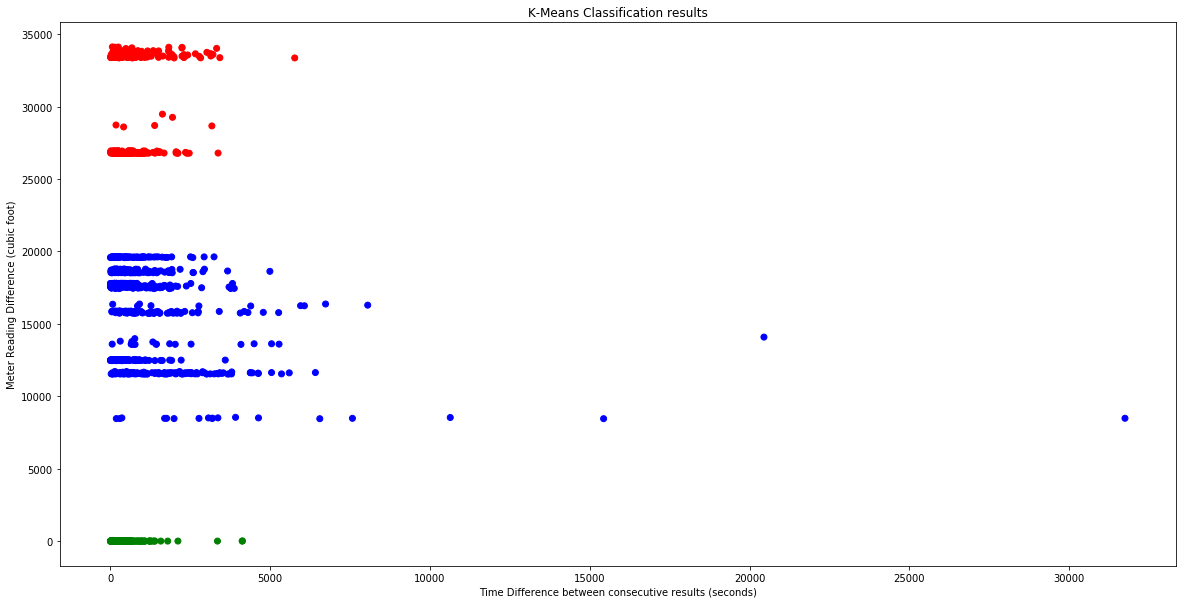

In [64]:
fig, ax = plt.subplots(figsize=(20,10))

colors = ['green','red','blue']
x = df_malfunction_2["Time Difference"].values
y = df_malfunction_2["Difference"].values
c= df_malfunction_2["Predicted Label"].apply(lambda x: colors[x]).values

ax.scatter(x, y, c=c)

ax.set_ylabel("Meter Reading Difference (cubic foot)")
ax.set_xlabel("Time Difference between consecutive results (seconds)")
plt.title('K-Means Classification results')

Based on the output above, the severity of the malfunctioning meters can be based on either meter readings where the higher difference in meter readings are the most severe cases (red) followed by points in blue which are the moderate cases and points in green which are the least severe cases. From this plot, the division can be easily seen as it is determine by the difference in meter readings and not the time difference between two consequtive readings. This analysis can value add to the gas companies as they could use this data to see which cases occur frequently and prompt the gas company to perform inspection and retification according. 